# Multi-Layer Perceptron (MLP)
This notebook builts an MLP for classification, same way as described in [Cepeda Humerez et al. (2019)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007290)

Hyperparameters to use:

````python
input_size = 200  # Adjust based on dataset
hidden_size = [300, 200] # 300 and 200 LTUs
output_size = 2  # Number of classes
dropout_rate = 0.5 # This wasn't specified in the paper, but choose any
learning_rate = 0.001 # Not specified in the paper
epochs = 100 # Not specified in the paper
batch_size = 16 # Not specified in the paper
````

The model architecture is in ``MLP.py``

Load the MLP model codes from ``src``

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tqdm
from sympy import sqrt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Import all the functions from the 'src' directory, we import all the functions from each module so we can use them straight away
from ssa_simulation import *
from ssa_analysis import *
from ssa_classification import *
from models.MLP import MLP 
from utils.set_seed import set_seed
from utils.load_data import load_and_split_data
import optuna
%load_ext autoreload
%autoreload 2

/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Example usage to train an MLP

In [3]:
# Example usage
input_size = 200  # Adjust based on dataset
hidden_size = [300, 200]
output_size = 2  # Number of classes
dropout_rate = 0.5
learning_rate = 0.001
epochs = 100
batch_size = 16

# Generate synthetic data
X_train = torch.randn(1000, input_size)
y_train = torch.randint(0, output_size, (1000,))
X_val = torch.randn(200, input_size)
y_val = torch.randint(0, output_size, (200,))

# Convert to DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize and train model
file_path = "mlp_model.pth"
model = MLP(input_size, hidden_size, output_size, dropout_rate, learning_rate)
history = model.train_model(train_loader, val_loader, epochs, save_path=file_path)

# Load best model and evaluate
model.load_model(file_path)
test_acc = model.evaluate(val_loader)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Make predictions
X_test = torch.randn(5, input_size)
predictions = model.predict(X_test)
print("Predicted classes:", predictions)

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.8790, Train Acc: 0.4730
Validation Acc: 0.4950
✅ Model saved at mlp_model.pth (Best Validation Acc: 0.4950)
Epoch [2/100], Loss: 1.4478, Train Acc: 0.5380
Validation Acc: 0.4500
No improvement (1/10).
Epoch [3/100], Loss: 1.0521, Train Acc: 0.5880
Validation Acc: 0.4750
No improvement (2/10).
Epoch [4/100], Loss: 0.9586, Train Acc: 0.6130
Validation Acc: 0.4900
No improvement (3/10).
Epoch [5/100], Loss: 0.8543, Train Acc: 0.6360
Validation Acc: 0.5050
✅ Model saved at mlp_model.pth (Best Validation Acc: 0.5050)
Epoch [6/100], Loss: 0.7486, Train Acc: 0.6380
Validation Acc: 0.4850
No improvement (1/10).
Epoch [7/100], Loss: 0.6732, Train Acc: 0.6720
Validation Acc: 0.5050
No improvement (2/10).
Epoch [8/100], Loss: 0.7137, Train Acc: 0.6450
Validation Acc: 0.5100
✅ Model saved at mlp_model.pth (Best Validation Acc: 0.5100)
Epoch [9/100], Loss: 0.5757, Train Acc: 0.7190
V

Train the MLP using SSA data, we need to first standardise the data. If we don't, the loss will be showing as nan, which is incorrect. 

In [2]:
# Train MLP model using SSA data
output_file = 'data/mRNA_trajectories_example.csv'
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(output_file, split_val_size=0.2) # we must define split_val_size here to get a validation set
print(X_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [3]:
# Standardize the data 
# If your input features are too large (e.g., >1000) or too small (<0.0001), it can cause unstable training, so it's better to standardize the data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print(X_train)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

[[ 0.         -0.40815408 -0.27320156 ... -0.06262243 -0.08873565
  -0.08873565]
 [ 0.         -0.40815408 -0.27320156 ... -0.06262243 -0.08873565
  -0.08873565]
 [ 0.          0.96668072 -0.27320156 ... -0.06262243 -0.08873565
  -0.08873565]
 ...
 [ 0.         -0.40815408 -0.27320156 ... -0.06262243 -0.08873565
  -0.08873565]
 [ 0.         -0.40815408 -0.27320156 ... -0.06262243 11.26942767
  -0.08873565]
 [ 0.         -0.40815408 -0.27320156 ... -0.06262243 -0.08873565
  -0.08873565]]
X_train shape: (256, 144)
y_train shape: (256,)


🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/1000], Loss: 1.2740, Train Acc: 0.5508
Validation Acc: 0.7031
Epoch [2/1000], Loss: 0.8994, Train Acc: 0.7031
Validation Acc: 0.6875
No improvement (1/10).
Epoch [3/1000], Loss: 0.7816, Train Acc: 0.7539
Validation Acc: 0.6875
No improvement (2/10).
Epoch [4/1000], Loss: 0.7404, Train Acc: 0.7617
Validation Acc: 0.6875
No improvement (3/10).
Epoch [5/1000], Loss: 0.5665, Train Acc: 0.7773
Validation Acc: 0.7344
Epoch [6/1000], Loss: 0.6121, Train Acc: 0.7305
Validation Acc: 0.6719
No improvement (1/10).
Epoch [7/1000], Loss: 0.6311, Train Acc: 0.7578
Validation Acc: 0.6719
No improvement (2/10).
Epoch [8/1000], Loss: 0.4116, Train Acc: 0.8281
Validation Acc: 0.6562
No improvement (3/10).
Epoch [9/1000], Loss: 0.4543, Train Acc: 0.8047
Validation Acc: 0.6406
No improvement (4/10).
Epoch [10/1000], Loss: 0.4588, Train Acc: 0.8086
Validation Acc: 0.7188
No improvement (5/10).
Epoch [11/1

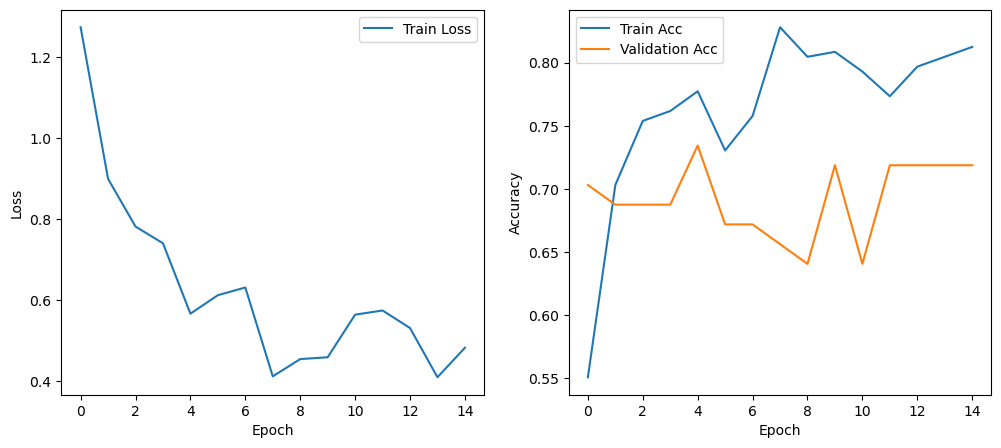

In [ ]:
set_seed(42)

# Define model parameters
input_size = X_train.shape[1]
# print(f"input_size: {input_size}")
output_size = len(set(y_train))  # Number of classes
hidden_size = [300, 200]
dropout_rate = 0.5
learning_rate = 0.001
epochs = 1000
batch_size = 32

train_loader = DataLoader(TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)),
    batch_size=batch_size, shuffle=True
)

val_loader = DataLoader(TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.long)),
    batch_size=batch_size, shuffle=False
)

test_loader = DataLoader(TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)),
    batch_size=batch_size, shuffle=False
)

model = MLP(input_size, hidden_size, output_size, dropout_rate, learning_rate)
history = model.train_model(train_loader, val_loader, epochs=epochs, patience=10)

# Evaluate MLP model
mlp_accuracy = model.evaluate(test_loader)
print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Same as above, but getting the accuracy in a one-liner

In [9]:
# Train SVM model using SSA data
output_file = 'data/mRNA_trajectories_example.csv'
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(output_file, split_val_size=0.2) # we must define split_val_size here to get a validation set
mlp_accuracy = mlp_classifier(X_train, X_val, X_test, y_train, y_val, y_test, epochs=100)

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 0.9696, Train Acc: 0.6641
Validation Acc: 0.6562
Epoch [2/100], Loss: 0.7469, Train Acc: 0.7422
Validation Acc: 0.6406
No improvement (1/10).
Epoch [3/100], Loss: 0.5988, Train Acc: 0.7852
Validation Acc: 0.6406
No improvement (2/10).
Epoch [4/100], Loss: 0.4658, Train Acc: 0.8008
Validation Acc: 0.7344
Epoch [5/100], Loss: 0.4959, Train Acc: 0.7773
Validation Acc: 0.6719
No improvement (1/10).
Epoch [6/100], Loss: 0.4065, Train Acc: 0.8125
Validation Acc: 0.6562
No improvement (2/10).
Epoch [7/100], Loss: 0.4356, Train Acc: 0.8047
Validation Acc: 0.6406
No improvement (3/10).
Epoch [8/100], Loss: 0.4291, Train Acc: 0.8008
Validation Acc: 0.6562
No improvement (4/10).
Epoch [9/100], Loss: 0.4436, Train Acc: 0.8086
Validation Acc: 0.7344
No improvement (5/10).
Epoch [10/100], Loss: 0.4074, Train Acc: 0.8008
Validation Acc: 0.6719
No improvement (6/10).
Epoch [11/100], Loss:

Example script finetuning hyperparameters, we'll ue a *Baysian optimisation* method for efficiency and effectiveness. It samples hyperparameter space based on previous results. 

We use the ``Optuna`` library for this.

Note that the data used to train is relatively small so this won't take long. In reality, this will take much longer, especially if the input data is large and if we use a grid search strategy.

In [9]:
# Set seed for reproducibility
set_seed(42)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(
    'data/mRNA_trajectories_example.csv', split_val_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

def objective(trial):
    hidden_size = [
        trial.suggest_categorical("hidden_size_1", [64, 128, 256]),
        trial.suggest_categorical("hidden_size_2", [32, 64, 128])
    ]
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_categorical("learning_rate", [0.01, 0.001, 0.0001])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    epochs = trial.suggest_categorical("epochs", [10, 50, 100])
    optimizer_choice = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])

    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)),
        batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(
        TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)),
        batch_size=batch_size, shuffle=False)

    model = MLP(
        input_size=X_train.shape[1],
        hidden_size=hidden_size,
        output_size=len(set(y_train)),
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        optimizer=optimizer_choice
    )

    history = model.train_model(train_loader, val_loader, epochs=epochs, patience=10)
    val_accuracy = model.evaluate(val_loader)

    return val_accuracy

# Run optimization study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Display the best hyperparameters
print(f"\nBest Validation Accuracy: {study.best_value:.4f}")
print("Best Hyperparameters:", study.best_params)


[I 2025-03-23 16:42:35,366] A new study created in memory with name: no-name-86c3a569-c270-4d64-837f-12c8fd1fc1b3


[I 2025-03-23 16:42:35,452] Trial 0 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.49044929121867187, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.65625.
[I 2025-03-23 16:42:35,522] Trial 1 finished with value: 0.671875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 128, 'dropout_rate': 0.1394447801350226, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.671875.


🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.9526, Train Acc: 0.6406
Validation Acc: 0.6406
Epoch [2/50], Loss: 0.6258, Train Acc: 0.7891
Validation Acc: 0.7188
Epoch [3/50], Loss: 0.6358, Train Acc: 0.7539
Validation Acc: 0.6562
No improvement (1/10).
Epoch [4/50], Loss: 0.6533, Train Acc: 0.7773
Validation Acc: 0.6562
No improvement (2/10).
Epoch [5/50], Loss: 0.4816, Train Acc: 0.8008
Validation Acc: 0.6406
No improvement (3/10).
Epoch [6/50], Loss: 0.4951, Train Acc: 0.7656
Validation Acc: 0.6406
No improvement (4/10).
Epoch [7/50], Loss: 0.4975, Train Acc: 0.8008
Validation Acc: 0.6562
No improvement (5/10).
Epoch [8/50], Loss: 0.5266, Train Acc: 0.7852
Validation Acc: 0.7188
No improvement (6/10).
Epoch [9/50], Loss: 0.5286, Train Acc: 0.7383
Validation Acc: 0.6406
No improvement (7/10).
Epoch [10/50], Loss: 0.5399, Train Acc: 0.7969
Validation Acc: 0.6406
No improvement (8/10).
Epoch [11/50], Loss: 0.4375, Tr

[I 2025-03-23 16:42:35,605] Trial 2 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.23947284675250247, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.671875.


Epoch [9/50], Loss: 0.4090, Train Acc: 0.7773
Validation Acc: 0.6719
No improvement (4/10).
Epoch [10/50], Loss: 0.3842, Train Acc: 0.8320
Validation Acc: 0.6719
No improvement (5/10).
Epoch [11/50], Loss: 0.3687, Train Acc: 0.8320
Validation Acc: 0.6719
No improvement (6/10).
Epoch [12/50], Loss: 0.3684, Train Acc: 0.8398
Validation Acc: 0.7344
No improvement (7/10).
Epoch [13/50], Loss: 0.3840, Train Acc: 0.8398
Validation Acc: 0.6719
No improvement (8/10).
Epoch [14/50], Loss: 0.3772, Train Acc: 0.8086
Validation Acc: 0.6875
No improvement (9/10).
Epoch [15/50], Loss: 0.3812, Train Acc: 0.8320
Validation Acc: 0.6719
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 1.2182, Train Acc: 0.6055
Validation Acc: 0.6562
Epoch [2/50], Loss: 0.6541, Train Acc: 0.7305
Validation Acc: 0.6406
No improvement (1/10).
Epoch [3/50], Loss: 0.5233, T

[I 2025-03-23 16:42:35,829] Trial 3 finished with value: 0.734375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.11637992074980122, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 3 with value: 0.734375.
[I 2025-03-23 16:42:35,953] Trial 4 finished with value: 0.625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.295439310991793, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.734375.


Epoch [11/50], Loss: 0.4222, Train Acc: 0.8008
Validation Acc: 0.7344
No improvement (7/10).
Epoch [12/50], Loss: 0.3953, Train Acc: 0.8125
Validation Acc: 0.6719
No improvement (8/10).
Epoch [13/50], Loss: 0.3846, Train Acc: 0.8359
Validation Acc: 0.7344
No improvement (9/10).
Epoch [14/50], Loss: 0.3885, Train Acc: 0.8281
Validation Acc: 0.7344
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 0.8171, Train Acc: 0.6328
Validation Acc: 0.7188
Epoch [2/100], Loss: 0.5250, Train Acc: 0.7656
Validation Acc: 0.6719
No improvement (1/10).
Epoch [3/100], Loss: 0.4978, Train Acc: 0.7969
Validation Acc: 0.6719
No improvement (2/10).
Epoch [4/100], Loss: 0.4766, Train Acc: 0.8008
Validation Acc: 0.7344
Epoch [5/100], Loss: 0.4574, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (1/10).
Epoch [6/100], Loss: 0.4732, Train Acc: 0.8008
Va

[I 2025-03-23 16:42:36,145] Trial 5 finished with value: 0.671875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.39917974147629787, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.734375.


Epoch [4/100], Loss: 0.6813, Train Acc: 0.7109
Validation Acc: 0.6562
Epoch [5/100], Loss: 0.8950, Train Acc: 0.6758
Validation Acc: 0.6562
No improvement (1/10).
Epoch [6/100], Loss: 0.6481, Train Acc: 0.7305
Validation Acc: 0.6562
No improvement (2/10).
Epoch [7/100], Loss: 0.6289, Train Acc: 0.7148
Validation Acc: 0.6875
Epoch [8/100], Loss: 0.5149, Train Acc: 0.7891
Validation Acc: 0.6719
No improvement (1/10).
Epoch [9/100], Loss: 0.5563, Train Acc: 0.7656
Validation Acc: 0.7344
Epoch [10/100], Loss: 0.5373, Train Acc: 0.7539
Validation Acc: 0.7344
No improvement (1/10).
Epoch [11/100], Loss: 0.6523, Train Acc: 0.7734
Validation Acc: 0.7344
No improvement (2/10).
Epoch [12/100], Loss: 0.5864, Train Acc: 0.7500
Validation Acc: 0.7500
Epoch [13/100], Loss: 0.5510, Train Acc: 0.7656
Validation Acc: 0.7500
No improvement (1/10).
Epoch [14/100], Loss: 0.5877, Train Acc: 0.7617
Validation Acc: 0.7500
No improvement (2/10).
Epoch [15/100], Loss: 0.6233, Train Acc: 0.7617
Validation Acc: 

[I 2025-03-23 16:42:36,259] Trial 6 finished with value: 0.71875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 128, 'dropout_rate': 0.40127939898651654, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 3 with value: 0.734375.
[I 2025-03-23 16:42:36,375] Trial 7 finished with value: 0.671875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 128, 'dropout_rate': 0.10938655861500966, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.734375.


Epoch [9/50], Loss: 0.5876, Train Acc: 0.7422
Validation Acc: 0.6719
No improvement (8/10).
Epoch [10/50], Loss: 0.5325, Train Acc: 0.7812
Validation Acc: 0.6719
No improvement (9/10).
Epoch [11/50], Loss: 0.5051, Train Acc: 0.8125
Validation Acc: 0.7344
Epoch [12/50], Loss: 0.5305, Train Acc: 0.7891
Validation Acc: 0.7188
No improvement (1/10).
Epoch [13/50], Loss: 0.4541, Train Acc: 0.8125
Validation Acc: 0.7188
No improvement (2/10).
Epoch [14/50], Loss: 0.4820, Train Acc: 0.7969
Validation Acc: 0.6562
No improvement (3/10).
Epoch [15/50], Loss: 0.4900, Train Acc: 0.7930
Validation Acc: 0.6562
No improvement (4/10).
Epoch [16/50], Loss: 0.4472, Train Acc: 0.8125
Validation Acc: 0.6562
No improvement (5/10).
Epoch [17/50], Loss: 0.4498, Train Acc: 0.8008
Validation Acc: 0.7188
No improvement (6/10).
Epoch [18/50], Loss: 0.4031, Train Acc: 0.8281
Validation Acc: 0.7188
No improvement (7/10).
Epoch [19/50], Loss: 0.4810, Train Acc: 0.7812
Validation Acc: 0.7188
No improvement (8/10).
E

[I 2025-03-23 16:42:36,414] Trial 8 finished with value: 0.625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.46774159394615267, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 10, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.734375.
[I 2025-03-23 16:42:36,528] Trial 9 finished with value: 0.640625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.40636073275011797, 'learning_rate': 0.0001, 'batch_size': 256, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.734375.


Validation Acc: 0.3125
No improvement (2/10).
Epoch [6/10], Loss: 1.3348, Train Acc: 0.4922
Validation Acc: 0.3281
No improvement (3/10).
Epoch [7/10], Loss: 1.3035, Train Acc: 0.4961
Validation Acc: 0.3281
No improvement (4/10).
Epoch [8/10], Loss: 1.2071, Train Acc: 0.4883
Validation Acc: 0.3750
Epoch [9/10], Loss: 1.3523, Train Acc: 0.5078
Validation Acc: 0.6094
Epoch [10/10], Loss: 1.1229, Train Acc: 0.5039
Validation Acc: 0.6250
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.8163, Train Acc: 0.5898
Validation Acc: 0.6250
Epoch [2/100], Loss: 1.7803, Train Acc: 0.5898
Validation Acc: 0.6250
No improvement (1/10).
Epoch [3/100], Loss: 1.5274, Train Acc: 0.5859
Validation Acc: 0.6250
No improvement (2/10).
Epoch [4/100], Loss: 1.6045, Train Acc: 0.5703
Validation Acc: 0.6406
Epoch [5/100], Loss: 1.7689, Train Acc: 0.5664
Validation Acc: 0.6406
No improvement (1/10).
Epoch [6/100], Loss: 1.7189, T

[I 2025-03-23 16:42:36,692] Trial 10 finished with value: 0.640625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.2030036479964592, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 3 with value: 0.734375.


Epoch [4/10], Loss: 0.9387, Train Acc: 0.6406
Validation Acc: 0.6406
No improvement (2/10).
Epoch [5/10], Loss: 0.8485, Train Acc: 0.6211
Validation Acc: 0.6250
No improvement (3/10).
Epoch [6/10], Loss: 0.8030, Train Acc: 0.6562
Validation Acc: 0.6250
No improvement (4/10).
Epoch [7/10], Loss: 0.8006, Train Acc: 0.6523
Validation Acc: 0.6406
No improvement (5/10).
Epoch [8/10], Loss: 0.7578, Train Acc: 0.6602
Validation Acc: 0.6406
No improvement (6/10).
Epoch [9/10], Loss: 0.7433, Train Acc: 0.6680
Validation Acc: 0.6406
No improvement (7/10).
Epoch [10/10], Loss: 0.6863, Train Acc: 0.6797
Validation Acc: 0.6406
No improvement (8/10).
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.8732, Train Acc: 0.6680
Validation Acc: 0.6406
Epoch [2/50], Loss: 0.6426, Train Acc: 0.7188
Validation Acc: 0.6562
Epoch [3/50], Loss: 0.5825, Train Acc: 0.7461
Validation Acc: 0.6562
No improvement (1/10).
Epoch [4/50]

[I 2025-03-23 16:42:36,973] Trial 11 finished with value: 0.734375 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.3519452124578958, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 3 with value: 0.734375.


Epoch [8/50], Loss: 0.4226, Train Acc: 0.8047
Validation Acc: 0.7344
Epoch [9/50], Loss: 0.3876, Train Acc: 0.8281
Validation Acc: 0.7344
No improvement (1/10).
Epoch [10/50], Loss: 0.4112, Train Acc: 0.8047
Validation Acc: 0.7500
Epoch [11/50], Loss: 0.4157, Train Acc: 0.8125
Validation Acc: 0.6875
No improvement (1/10).
Epoch [12/50], Loss: 0.4428, Train Acc: 0.7891
Validation Acc: 0.6875
No improvement (2/10).
Epoch [13/50], Loss: 0.4268, Train Acc: 0.8164
Validation Acc: 0.7344
No improvement (3/10).
Epoch [14/50], Loss: 0.4278, Train Acc: 0.8125
Validation Acc: 0.7344
No improvement (4/10).
Epoch [15/50], Loss: 0.4184, Train Acc: 0.8047
Validation Acc: 0.7344
No improvement (5/10).
Epoch [16/50], Loss: 0.4001, Train Acc: 0.8086
Validation Acc: 0.6719
No improvement (6/10).
Epoch [17/50], Loss: 0.4046, Train Acc: 0.8203
Validation Acc: 0.7344
No improvement (7/10).
Epoch [18/50], Loss: 0.4260, Train Acc: 0.7969
Validation Acc: 0.7344
No improvement (8/10).
Epoch [19/50], Loss: 0.42

[I 2025-03-23 16:42:37,155] Trial 12 finished with value: 0.734375 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.30798443485777316, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 3 with value: 0.734375.


Epoch [3/50], Loss: 0.5960, Train Acc: 0.7344
Validation Acc: 0.7500
Epoch [4/50], Loss: 0.5823, Train Acc: 0.7578
Validation Acc: 0.6719
No improvement (1/10).
Epoch [5/50], Loss: 0.5135, Train Acc: 0.7812
Validation Acc: 0.6719
No improvement (2/10).
Epoch [6/50], Loss: 0.4926, Train Acc: 0.7930
Validation Acc: 0.6719
No improvement (3/10).
Epoch [7/50], Loss: 0.5241, Train Acc: 0.7812
Validation Acc: 0.6875
No improvement (4/10).
Epoch [8/50], Loss: 0.4264, Train Acc: 0.7930
Validation Acc: 0.7500
No improvement (5/10).
Epoch [9/50], Loss: 0.4126, Train Acc: 0.8203
Validation Acc: 0.7500
No improvement (6/10).
Epoch [10/50], Loss: 0.4431, Train Acc: 0.7969
Validation Acc: 0.6719
No improvement (7/10).
Epoch [11/50], Loss: 0.4074, Train Acc: 0.8320
Validation Acc: 0.6719
No improvement (8/10).
Epoch [12/50], Loss: 0.4523, Train Acc: 0.7695
Validation Acc: 0.7344
No improvement (9/10).
Epoch [13/50], Loss: 0.4130, Train Acc: 0.7930
Validation Acc: 0.7344
No improvement (10/10).
Stoppi

[I 2025-03-23 16:42:37,388] Trial 13 finished with value: 0.71875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.31551860754366284, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 3 with value: 0.734375.


Epoch [5/50], Loss: 0.4943, Train Acc: 0.7969
Validation Acc: 0.6719
No improvement (4/10).
Epoch [6/50], Loss: 0.4401, Train Acc: 0.7969
Validation Acc: 0.6719
No improvement (5/10).
Epoch [7/50], Loss: 0.4678, Train Acc: 0.7969
Validation Acc: 0.7344
Epoch [8/50], Loss: 0.4498, Train Acc: 0.8086
Validation Acc: 0.7344
No improvement (1/10).
Epoch [9/50], Loss: 0.4321, Train Acc: 0.8008
Validation Acc: 0.7344
No improvement (2/10).
Epoch [10/50], Loss: 0.3832, Train Acc: 0.8242
Validation Acc: 0.7344
No improvement (3/10).
Epoch [11/50], Loss: 0.3934, Train Acc: 0.8320
Validation Acc: 0.7188
No improvement (4/10).
Epoch [12/50], Loss: 0.4345, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (5/10).
Epoch [13/50], Loss: 0.3909, Train Acc: 0.8164
Validation Acc: 0.7188
No improvement (6/10).
Epoch [14/50], Loss: 0.4007, Train Acc: 0.8125
Validation Acc: 0.7188
No improvement (7/10).
Epoch [15/50], Loss: 0.4067, Train Acc: 0.8242
Validation Acc: 0.7188
No improvement (8/10).
Epoch

[I 2025-03-23 16:42:37,610] Trial 14 finished with value: 0.640625 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.20978180606912689, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 3 with value: 0.734375.


Epoch [3/50], Loss: 0.6172, Train Acc: 0.7227
Validation Acc: 0.6406
Epoch [4/50], Loss: 0.5654, Train Acc: 0.7344
Validation Acc: 0.6406
No improvement (1/10).
Epoch [5/50], Loss: 0.5475, Train Acc: 0.7695
Validation Acc: 0.6562
Epoch [6/50], Loss: 0.4894, Train Acc: 0.7891
Validation Acc: 0.6719
Epoch [7/50], Loss: 0.4840, Train Acc: 0.7969
Validation Acc: 0.6562
No improvement (1/10).
Epoch [8/50], Loss: 0.4901, Train Acc: 0.7891
Validation Acc: 0.6406
No improvement (2/10).
Epoch [9/50], Loss: 0.4818, Train Acc: 0.7773
Validation Acc: 0.6406
No improvement (3/10).
Epoch [10/50], Loss: 0.4728, Train Acc: 0.8086
Validation Acc: 0.6250
No improvement (4/10).
Epoch [11/50], Loss: 0.4419, Train Acc: 0.7852
Validation Acc: 0.6250
No improvement (5/10).
Epoch [12/50], Loss: 0.4217, Train Acc: 0.8086
Validation Acc: 0.6406
No improvement (6/10).
Epoch [13/50], Loss: 0.4326, Train Acc: 0.7930
Validation Acc: 0.6406
No improvement (7/10).
Epoch [14/50], Loss: 0.4469, Train Acc: 0.8086
Valida

[I 2025-03-23 16:42:37,805] Trial 15 finished with value: 0.75 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.35208563127263837, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.


Epoch [2/50], Loss: 0.7185, Train Acc: 0.7305
Validation Acc: 0.6719
Epoch [3/50], Loss: 0.5589, Train Acc: 0.7656
Validation Acc: 0.7188
Epoch [4/50], Loss: 0.5859, Train Acc: 0.7344
Validation Acc: 0.7656
Epoch [5/50], Loss: 0.5002, Train Acc: 0.7812
Validation Acc: 0.7656
No improvement (1/10).
Epoch [6/50], Loss: 0.5324, Train Acc: 0.7461
Validation Acc: 0.7500
No improvement (2/10).
Epoch [7/50], Loss: 0.5351, Train Acc: 0.7812
Validation Acc: 0.7500
No improvement (3/10).
Epoch [8/50], Loss: 0.4618, Train Acc: 0.7852
Validation Acc: 0.7500
No improvement (4/10).
Epoch [9/50], Loss: 0.4927, Train Acc: 0.7812
Validation Acc: 0.7344
No improvement (5/10).
Epoch [10/50], Loss: 0.4450, Train Acc: 0.8086
Validation Acc: 0.7344
No improvement (6/10).
Epoch [11/50], Loss: 0.4944, Train Acc: 0.7891
Validation Acc: 0.6875
No improvement (7/10).
Epoch [12/50], Loss: 0.4316, Train Acc: 0.8047
Validation Acc: 0.7344
No improvement (8/10).
Epoch [13/50], Loss: 0.4275, Train Acc: 0.8125
Validat

[I 2025-03-23 16:42:37,953] Trial 16 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.25873425252594723, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.


Epoch [3/10], Loss: 0.7350, Train Acc: 0.7109
Validation Acc: 0.6562
No improvement (2/10).
Epoch [4/10], Loss: 0.7357, Train Acc: 0.7188
Validation Acc: 0.6562
No improvement (3/10).
Epoch [5/10], Loss: 0.7025, Train Acc: 0.7188
Validation Acc: 0.6406
No improvement (4/10).
Epoch [6/10], Loss: 0.7690, Train Acc: 0.7031
Validation Acc: 0.6406
No improvement (5/10).
Epoch [7/10], Loss: 0.6807, Train Acc: 0.7148
Validation Acc: 0.6406
No improvement (6/10).
Epoch [8/10], Loss: 0.7332, Train Acc: 0.7305
Validation Acc: 0.6250
No improvement (7/10).
Epoch [9/10], Loss: 0.5704, Train Acc: 0.7266
Validation Acc: 0.6562
No improvement (8/10).
Epoch [10/10], Loss: 0.6933, Train Acc: 0.7070
Validation Acc: 0.6562
No improvement (9/10).
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 1.0105, Train Acc: 0.6367
Validation Acc: 0.6094
Epoch [2/50], Loss: 0.6169, Train Acc: 0.7266
Validation Acc: 0.6094
No improveme

[I 2025-03-23 16:42:38,270] Trial 17 finished with value: 0.640625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.1675001835378332, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.


Validation Acc: 0.6406
No improvement (9/10).
Epoch [23/50], Loss: 0.3967, Train Acc: 0.8164
Validation Acc: 0.6406
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.8778, Train Acc: 0.5898
Validation Acc: 0.5625
Epoch [2/50], Loss: 0.8132, Train Acc: 0.5781
Validation Acc: 0.5781
Epoch [3/50], Loss: 0.8208, Train Acc: 0.6797
Validation Acc: 0.6094
Epoch [4/50], Loss: 0.6990, Train Acc: 0.7070
Validation Acc: 0.6250
Epoch [5/50], Loss: 0.7135, Train Acc: 0.7188
Validation Acc: 0.6406
Epoch [6/50], Loss: 0.6246, Train Acc: 0.7188
Validation Acc: 0.6406
No improvement (1/10).
Epoch [7/50], Loss: 0.6542, Train Acc: 0.7305
Validation Acc: 0.6250
No improvement (2/10).
Epoch [8/50], Loss: 0.6010, Train Acc: 0.7656
Validation Acc: 0.6250
No improvement (3/10).
Epoch [9/50], Loss: 0.5686, Train Acc: 0.7461
Validation Acc: 0.6250
No improvem

[I 2025-03-23 16:42:38,462] Trial 18 finished with value: 0.625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.35490432780816095, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 15 with value: 0.75.
[I 2025-03-23 16:42:38,603] Trial 19 finished with value: 0.609375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.10432128270631955, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.


Epoch [15/50], Loss: 0.5388, Train Acc: 0.7578
Validation Acc: 0.6250
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/10], Loss: 0.9955, Train Acc: 0.6406
Validation Acc: 0.6094
Epoch [2/10], Loss: 0.9890, Train Acc: 0.6289
Validation Acc: 0.5938
No improvement (1/10).
Epoch [3/10], Loss: 0.9255, Train Acc: 0.6367
Validation Acc: 0.6094
No improvement (2/10).
Epoch [4/10], Loss: 0.8110, Train Acc: 0.6367
Validation Acc: 0.6094
No improvement (3/10).
Epoch [5/10], Loss: 0.8397, Train Acc: 0.6562
Validation Acc: 0.6250
Epoch [6/10], Loss: 0.8098, Train Acc: 0.6602
Validation Acc: 0.6250
No improvement (1/10).
Epoch [7/10], Loss: 0.8287, Train Acc: 0.6719
Validation Acc: 0.6094
No improvement (2/10).
Epoch [8/10], Loss: 0.8144, Train Acc: 0.6523
Validation Acc: 0.6094
No improvement (3/10).
Epoch [9/10], Loss: 0.6506, Train Acc: 0.7109
Validation 

[I 2025-03-23 16:42:38,892] Trial 20 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.4360368000404029, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.


Epoch [20/50], Loss: 0.4716, Train Acc: 0.7852
Validation Acc: 0.6562
No improvement (9/10).
Epoch [21/50], Loss: 0.4153, Train Acc: 0.8086
Validation Acc: 0.6562
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.9943, Train Acc: 0.5859
Validation Acc: 0.6094
Epoch [2/50], Loss: 0.7040, Train Acc: 0.7266
Validation Acc: 0.6719
Epoch [3/50], Loss: 0.6903, Train Acc: 0.7578
Validation Acc: 0.6875
Epoch [4/50], Loss: 0.6091, Train Acc: 0.7695
Validation Acc: 0.6875
No improvement (1/10).
Epoch [5/50], Loss: 0.5335, Train Acc: 0.7969
Validation Acc: 0.6875
No improvement (2/10).
Epoch [6/50], Loss: 0.4782, Train Acc: 0.7852
Validation Acc: 0.7500
Epoch [7/50], Loss: 0.5092, Train Acc: 0.7734
Validation Acc: 0.6875
No improvement (1/10).
Epoch [8/50], Loss: 0.5173, Train Acc: 0.7812
Validation Acc: 0.6719
No improvement (2/10).
Epoch [9/5

[I 2025-03-23 16:42:39,113] Trial 21 finished with value: 0.65625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.3760390490467438, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.


Epoch [14/50], Loss: 0.4176, Train Acc: 0.8008
Validation Acc: 0.7188
No improvement (8/10).
Epoch [15/50], Loss: 0.3964, Train Acc: 0.8242
Validation Acc: 0.7188
No improvement (9/10).
Epoch [16/50], Loss: 0.4469, Train Acc: 0.8125
Validation Acc: 0.6562
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.9313, Train Acc: 0.6641
Validation Acc: 0.5781
Epoch [2/50], Loss: 0.8177, Train Acc: 0.6953
Validation Acc: 0.6250
Epoch [3/50], Loss: 0.5700, Train Acc: 0.7695
Validation Acc: 0.6719
Epoch [4/50], Loss: 0.5362, Train Acc: 0.7852
Validation Acc: 0.7344
Epoch [5/50], Loss: 0.5026, Train Acc: 0.7852
Validation Acc: 0.7188
No improvement (1/10).
Epoch [6/50], Loss: 0.4902, Train Acc: 0.7812
Validation Acc: 0.7188
No improvement (2/10).
Epoch [7/50], Loss: 0.4875, Train Acc: 0.7695
Validation Acc: 0.7344
No improvement (3/10).
Epoch [8/

[I 2025-03-23 16:42:39,309] Trial 22 finished with value: 0.71875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.3482054842358097, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.


Epoch [13/50], Loss: 0.4080, Train Acc: 0.7969
Validation Acc: 0.7344
No improvement (9/10).
Epoch [14/50], Loss: 0.4236, Train Acc: 0.8047
Validation Acc: 0.7188
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 1.3624, Train Acc: 0.5000
Validation Acc: 0.5469
Epoch [2/50], Loss: 0.9087, Train Acc: 0.6445
Validation Acc: 0.5625
Epoch [3/50], Loss: 0.7423, Train Acc: 0.6914
Validation Acc: 0.6250
Epoch [4/50], Loss: 0.7329, Train Acc: 0.6914
Validation Acc: 0.6250
No improvement (1/10).
Epoch [5/50], Loss: 0.6886, Train Acc: 0.7188
Validation Acc: 0.6719
Epoch [6/50], Loss: 0.7347, Train Acc: 0.7227
Validation Acc: 0.6719
No improvement (1/10).
Epoch [7/50], Loss: 0.6573, Train Acc: 0.7266
Validation Acc: 0.6562
No improvement (2/10).
Epoch [8/50], Loss: 0.5457, Train Acc: 0.7461
Validation Acc: 0.6562
No improvement (3/10).
Epoch [9/5

[I 2025-03-23 16:42:39,516] Trial 23 finished with value: 0.65625 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.2721146247355434, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.


Epoch [14/50], Loss: 0.4844, Train Acc: 0.7812
Validation Acc: 0.6562
No improvement (9/10).
Epoch [15/50], Loss: 0.4920, Train Acc: 0.7812
Validation Acc: 0.6562
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 1.2150, Train Acc: 0.5156
Validation Acc: 0.6406
Epoch [2/50], Loss: 0.7856, Train Acc: 0.6836
Validation Acc: 0.6406
No improvement (1/10).
Epoch [3/50], Loss: 0.6136, Train Acc: 0.7266
Validation Acc: 0.6406
No improvement (2/10).
Epoch [4/50], Loss: 0.6997, Train Acc: 0.7188
Validation Acc: 0.6562
Epoch [5/50], Loss: 0.5813, Train Acc: 0.7461
Validation Acc: 0.6562
No improvement (1/10).
Epoch [6/50], Loss: 0.5735, Train Acc: 0.7539
Validation Acc: 0.6562
No improvement (2/10).
Epoch [7/50], Loss: 0.5129, Train Acc: 0.7695
Validation Acc: 0.6562
No improvement (3/10).
Epoch [8/50], Loss: 0.5220, Train Acc: 0.7773
Validation

[I 2025-03-23 16:42:39,844] Trial 24 finished with value: 0.71875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.35157925421452585, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.


Epoch [14/50], Loss: 0.4601, Train Acc: 0.7930
Validation Acc: 0.7344
Epoch [15/50], Loss: 0.4612, Train Acc: 0.8047
Validation Acc: 0.7344
No improvement (1/10).
Epoch [16/50], Loss: 0.4151, Train Acc: 0.8086
Validation Acc: 0.7344
No improvement (2/10).
Epoch [17/50], Loss: 0.4205, Train Acc: 0.8242
Validation Acc: 0.6719
No improvement (3/10).
Epoch [18/50], Loss: 0.4249, Train Acc: 0.8125
Validation Acc: 0.6719
No improvement (4/10).
Epoch [19/50], Loss: 0.4323, Train Acc: 0.8164
Validation Acc: 0.6406
No improvement (5/10).
Epoch [20/50], Loss: 0.4448, Train Acc: 0.7969
Validation Acc: 0.7031
No improvement (6/10).
Epoch [21/50], Loss: 0.4770, Train Acc: 0.7930
Validation Acc: 0.7188
No improvement (7/10).
Epoch [22/50], Loss: 0.4423, Train Acc: 0.8125
Validation Acc: 0.7188
No improvement (8/10).
Epoch [23/50], Loss: 0.4347, Train Acc: 0.8086
Validation Acc: 0.7188
No improvement (9/10).
Epoch [24/50], Loss: 0.4421, Train Acc: 0.7930
Validation Acc: 0.7188
No improvement (10/10).

[I 2025-03-23 16:42:40,026] Trial 25 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.32105034783701014, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 15 with value: 0.75.
[I 2025-03-23 16:42:40,095] Trial 26 finished with value: 0.671875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.4319864558928657, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.


Epoch [5/50], Loss: 0.5647, Train Acc: 0.7578
Validation Acc: 0.6719
No improvement (1/10).
Epoch [6/50], Loss: 0.6043, Train Acc: 0.7539
Validation Acc: 0.6562
No improvement (2/10).
Epoch [7/50], Loss: 0.6499, Train Acc: 0.7539
Validation Acc: 0.6562
No improvement (3/10).
Epoch [8/50], Loss: 0.5468, Train Acc: 0.7578
Validation Acc: 0.6719
No improvement (4/10).
Epoch [9/50], Loss: 0.6437, Train Acc: 0.7305
Validation Acc: 0.6719
No improvement (5/10).
Epoch [10/50], Loss: 0.5588, Train Acc: 0.7734
Validation Acc: 0.6719
No improvement (6/10).
Epoch [11/50], Loss: 0.5529, Train Acc: 0.7383
Validation Acc: 0.6719
No improvement (7/10).
Epoch [12/50], Loss: 0.5130, Train Acc: 0.7812
Validation Acc: 0.6719
No improvement (8/10).
Epoch [13/50], Loss: 0.5341, Train Acc: 0.7734
Validation Acc: 0.6719
No improvement (9/10).
Epoch [14/50], Loss: 0.5386, Train Acc: 0.7539
Validation Acc: 0.6719
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using d

[I 2025-03-23 16:42:40,168] Trial 27 finished with value: 0.6875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.21552376767969542, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.
[I 2025-03-23 16:42:40,250] Trial 28 finished with value: 0.671875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.3739422799419675, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.
[I 2025-03-23 16:42:40,309] Trial 29 finished with value: 0.359375 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 128, 'dropout_rate': 0.4762000083064657, 'learning_rate': 0.0001, 'batch_size': 128, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 15 with value: 0.75.


Epoch [4/50], Loss: 0.6146, Train Acc: 0.7031
Validation Acc: 0.6875
No improvement (1/10).
Epoch [5/50], Loss: 0.5665, Train Acc: 0.7344
Validation Acc: 0.6875
No improvement (2/10).
Epoch [6/50], Loss: 0.5632, Train Acc: 0.7266
Validation Acc: 0.6719
No improvement (3/10).
Epoch [7/50], Loss: 0.5992, Train Acc: 0.7188
Validation Acc: 0.6719
No improvement (4/10).
Epoch [8/50], Loss: 0.5483, Train Acc: 0.7617
Validation Acc: 0.6875
No improvement (5/10).
Epoch [9/50], Loss: 0.4955, Train Acc: 0.7422
Validation Acc: 0.7031
Epoch [10/50], Loss: 0.5119, Train Acc: 0.7578
Validation Acc: 0.7031
No improvement (1/10).
Epoch [11/50], Loss: 0.4949, Train Acc: 0.7852
Validation Acc: 0.7031
No improvement (2/10).
Epoch [12/50], Loss: 0.4819, Train Acc: 0.7617
Validation Acc: 0.7031
No improvement (3/10).
Epoch [13/50], Loss: 0.4920, Train Acc: 0.7539
Validation Acc: 0.7031
No improvement (4/10).
Epoch [14/50], Loss: 0.4395, Train Acc: 0.7969
Validation Acc: 0.6875
No improvement (5/10).
Epoch 

[I 2025-03-23 16:42:40,532] Trial 30 finished with value: 0.71875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.278920738681501, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.
[I 2025-03-23 16:42:40,713] Trial 31 finished with value: 0.65625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.32110550259319914, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.


Validation Acc: 0.7188
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 1.0188, Train Acc: 0.6133
Validation Acc: 0.6562
Epoch [2/50], Loss: 0.6285, Train Acc: 0.7500
Validation Acc: 0.6562
No improvement (1/10).
Epoch [3/50], Loss: 0.6295, Train Acc: 0.7305
Validation Acc: 0.7344
Epoch [4/50], Loss: 0.5842, Train Acc: 0.7734
Validation Acc: 0.7344
No improvement (1/10).
Epoch [5/50], Loss: 0.4752, Train Acc: 0.7930
Validation Acc: 0.7344
No improvement (2/10).
Epoch [6/50], Loss: 0.4631, Train Acc: 0.7969
Validation Acc: 0.7188
No improvement (3/10).
Epoch [7/50], Loss: 0.4797, Train Acc: 0.7852
Validation Acc: 0.7188
No improvement (4/10).
Epoch [8/50], Loss: 0.4758, Train Acc: 0.7812
Validation Acc: 0.7344
No improvement (5/10).
Epoch [9/50], Loss: 0.5171, Train Acc: 0.7773
Validation Acc: 0.7188
No improvement (6/10).
Epoch [10/50

[I 2025-03-23 16:42:40,962] Trial 32 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.29441955425337085, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.


Epoch [17/50], Loss: 0.4047, Train Acc: 0.8242
Validation Acc: 0.7344
No improvement (9/10).
Epoch [18/50], Loss: 0.4163, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.8255, Train Acc: 0.6523
Validation Acc: 0.6562
Epoch [2/50], Loss: 0.5439, Train Acc: 0.7344
Validation Acc: 0.6250
No improvement (1/10).
Epoch [3/50], Loss: 0.4294, Train Acc: 0.8125
Validation Acc: 0.6406
No improvement (2/10).
Epoch [4/50], Loss: 0.4433, Train Acc: 0.7891
Validation Acc: 0.6562
No improvement (3/10).
Epoch [5/50], Loss: 0.4076, Train Acc: 0.8047
Validation Acc: 0.7188
Epoch [6/50], Loss: 0.4218, Train Acc: 0.8047
Validation Acc: 0.7188
No improvement (1/10).
Epoch [7/50], Loss: 0.4023, Train Acc: 0.8242
Validation Acc: 0.6562
No improvement (2/10).
Epoch [8/50], Loss: 0.3792, Train Acc: 0.8359
Validation

[I 2025-03-23 16:42:41,177] Trial 33 finished with value: 0.640625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.16789268134024932, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 15 with value: 0.75.
[I 2025-03-23 16:42:41,332] Trial 34 finished with value: 0.625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.24701662161304164, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.75.


Epoch [14/50], Loss: 0.3614, Train Acc: 0.8320
Validation Acc: 0.6406
No improvement (9/10).
Epoch [15/50], Loss: 0.4019, Train Acc: 0.8164
Validation Acc: 0.6406
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.8248, Train Acc: 0.6797
Validation Acc: 0.7344
Epoch [2/50], Loss: 0.6018, Train Acc: 0.7930
Validation Acc: 0.6875
No improvement (1/10).
Epoch [3/50], Loss: 0.4517, Train Acc: 0.7773
Validation Acc: 0.6562
No improvement (2/10).
Epoch [4/50], Loss: 0.4389, Train Acc: 0.8242
Validation Acc: 0.6875
No improvement (3/10).
Epoch [5/50], Loss: 0.4681, Train Acc: 0.8047
Validation Acc: 0.6250
No improvement (4/10).
Epoch [6/50], Loss: 0.4217, Train Acc: 0.8125
Validation Acc: 0.6875
No improvement (5/10).
Epoch [7/50], Loss: 0.4157, Train Acc: 0.8047
Validation Acc: 0.6406
No improvement (6/10).
Epoch [8/50], Loss: 0.3940, Train

[I 2025-03-23 16:42:41,427] Trial 35 finished with value: 0.765625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.3322045544006193, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:41,480] Trial 36 finished with value: 0.703125 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 128, 'dropout_rate': 0.3361122531479375, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:41,543] Trial 37 finished with value: 0.75 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.3713569719878887, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [6/100], Loss: 0.7473, Train Acc: 0.6953
Validation Acc: 0.6406
No improvement (3/10).
Epoch [7/100], Loss: 0.6532, Train Acc: 0.7344
Validation Acc: 0.6562
No improvement (4/10).
Epoch [8/100], Loss: 0.6764, Train Acc: 0.7070
Validation Acc: 0.6719
No improvement (5/10).
Epoch [9/100], Loss: 0.7529, Train Acc: 0.7227
Validation Acc: 0.7031
Epoch [10/100], Loss: 0.5721, Train Acc: 0.7656
Validation Acc: 0.7031
No improvement (1/10).
Epoch [11/100], Loss: 0.6120, Train Acc: 0.7539
Validation Acc: 0.7031
No improvement (2/10).
Epoch [12/100], Loss: 0.6107, Train Acc: 0.7773
Validation Acc: 0.7031
No improvement (3/10).
Epoch [13/100], Loss: 0.5929, Train Acc: 0.7539
Validation Acc: 0.7031
No improvement (4/10).
Epoch [14/100], Loss: 0.6015, Train Acc: 0.7578
Validation Acc: 0.7031
No improvement (5/10).
Epoch [15/100], Loss: 0.5227, Train Acc: 0.7734
Validation Acc: 0.7656
Epoch [16/100], Loss: 0.5047, Train Acc: 0.8008
Validation Acc: 0.7656
No improvement (1/10).
Epoch [17/100], 

[I 2025-03-23 16:42:41,602] Trial 38 finished with value: 0.71875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.37851714986002827, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:41,666] Trial 39 finished with value: 0.71875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.43107465224317343, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:41,750] Trial 40 finished with value: 0.671875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.40193804731179517, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 35 with value: 0.765625.


Epoch [4/100], Loss: 0.6262, Train Acc: 0.7383
Validation Acc: 0.6562
No improvement (1/10).
Epoch [5/100], Loss: 0.5101, Train Acc: 0.7695
Validation Acc: 0.7188
Epoch [6/100], Loss: 0.5275, Train Acc: 0.7500
Validation Acc: 0.7188
No improvement (1/10).
Epoch [7/100], Loss: 0.5221, Train Acc: 0.7617
Validation Acc: 0.6562
No improvement (2/10).
Epoch [8/100], Loss: 0.4859, Train Acc: 0.7891
Validation Acc: 0.6719
No improvement (3/10).
Epoch [9/100], Loss: 0.4391, Train Acc: 0.8086
Validation Acc: 0.6719
No improvement (4/10).
Epoch [10/100], Loss: 0.5146, Train Acc: 0.7852
Validation Acc: 0.6719
No improvement (5/10).
Epoch [11/100], Loss: 0.4266, Train Acc: 0.8281
Validation Acc: 0.6875
No improvement (6/10).
Epoch [12/100], Loss: 0.4295, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (7/10).
Epoch [13/100], Loss: 0.4332, Train Acc: 0.8281
Validation Acc: 0.6719
No improvement (8/10).
Epoch [14/100], Loss: 0.4215, Train Acc: 0.8008
Validation Acc: 0.7188
No improvement (9/

[I 2025-03-23 16:42:41,820] Trial 41 finished with value: 0.75 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.3381125924428554, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:41,882] Trial 42 finished with value: 0.734375 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.2875806061651408, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:41,947] Trial 43 finished with value: 0.671875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.3300437732812321, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [3/100], Loss: 0.5611, Train Acc: 0.7383
Validation Acc: 0.6875
No improvement (2/10).
Epoch [4/100], Loss: 0.5978, Train Acc: 0.7695
Validation Acc: 0.7031
No improvement (3/10).
Epoch [5/100], Loss: 0.6017, Train Acc: 0.7773
Validation Acc: 0.7656
Epoch [6/100], Loss: 0.5039, Train Acc: 0.7500
Validation Acc: 0.7656
No improvement (1/10).
Epoch [7/100], Loss: 0.4709, Train Acc: 0.7734
Validation Acc: 0.7656
No improvement (2/10).
Epoch [8/100], Loss: 0.4941, Train Acc: 0.7812
Validation Acc: 0.7812
Epoch [9/100], Loss: 0.4852, Train Acc: 0.7773
Validation Acc: 0.7188
No improvement (1/10).
Epoch [10/100], Loss: 0.4270, Train Acc: 0.8125
Validation Acc: 0.7188
No improvement (2/10).
Epoch [11/100], Loss: 0.4432, Train Acc: 0.8203
Validation Acc: 0.7188
No improvement (3/10).
Epoch [12/100], Loss: 0.4317, Train Acc: 0.8203
Validation Acc: 0.7188
No improvement (4/10).
Epoch [13/100], Loss: 0.4178, Train Acc: 0.8164
Validation Acc: 0.7031
No improvement (5/10).
Epoch [14/100], Los

[I 2025-03-23 16:42:42,079] Trial 44 finished with value: 0.640625 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.37989032372650156, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:42,156] Trial 45 finished with value: 0.671875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.41200400349780586, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [5/100], Loss: 0.6211, Train Acc: 0.7344
Validation Acc: 0.6562
No improvement (1/10).
Epoch [6/100], Loss: 0.5777, Train Acc: 0.7734
Validation Acc: 0.6562
No improvement (2/10).
Epoch [7/100], Loss: 0.5344, Train Acc: 0.7539
Validation Acc: 0.6562
No improvement (3/10).
Epoch [8/100], Loss: 0.5451, Train Acc: 0.7383
Validation Acc: 0.6719
Epoch [9/100], Loss: 0.5405, Train Acc: 0.7383
Validation Acc: 0.6875
Epoch [10/100], Loss: 0.4891, Train Acc: 0.7578
Validation Acc: 0.6562
No improvement (1/10).
Epoch [11/100], Loss: 0.5082, Train Acc: 0.7617
Validation Acc: 0.6562
No improvement (2/10).
Epoch [12/100], Loss: 0.4742, Train Acc: 0.7852
Validation Acc: 0.6719
No improvement (3/10).
Epoch [13/100], Loss: 0.4631, Train Acc: 0.8008
Validation Acc: 0.6719
No improvement (4/10).
Epoch [14/100], Loss: 0.4321, Train Acc: 0.8086
Validation Acc: 0.6719
No improvement (5/10).
Epoch [15/100], Loss: 0.4523, Train Acc: 0.8086
Validation Acc: 0.6719
No improvement (6/10).
Epoch [16/100], L

[I 2025-03-23 16:42:42,256] Trial 46 finished with value: 0.65625 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.13921963013925887, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:42,317] Trial 47 finished with value: 0.640625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.3012250962042932, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.765625.


Epoch [2/100], Loss: 0.5001, Train Acc: 0.7891
Validation Acc: 0.7188
Epoch [3/100], Loss: 0.4624, Train Acc: 0.7773
Validation Acc: 0.6719
No improvement (1/10).
Epoch [4/100], Loss: 0.4096, Train Acc: 0.8281
Validation Acc: 0.6562
No improvement (2/10).
Epoch [5/100], Loss: 0.3921, Train Acc: 0.8164
Validation Acc: 0.7188
No improvement (3/10).
Epoch [6/100], Loss: 0.4010, Train Acc: 0.8203
Validation Acc: 0.7188
No improvement (4/10).
Epoch [7/100], Loss: 0.4026, Train Acc: 0.8320
Validation Acc: 0.7188
No improvement (5/10).
Epoch [8/100], Loss: 0.3816, Train Acc: 0.8164
Validation Acc: 0.7188
No improvement (6/10).
Epoch [9/100], Loss: 0.3752, Train Acc: 0.8203
Validation Acc: 0.7188
No improvement (7/10).
Epoch [10/100], Loss: 0.3722, Train Acc: 0.8281
Validation Acc: 0.6562
No improvement (8/10).
Epoch [11/100], Loss: 0.3777, Train Acc: 0.8281
Validation Acc: 0.7188
No improvement (9/10).
Epoch [12/100], Loss: 0.3859, Train Acc: 0.8281
Validation Acc: 0.6562
No improvement (10/1

[I 2025-03-23 16:42:42,403] Trial 48 finished with value: 0.609375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.3656419318638371, 'learning_rate': 0.0001, 'batch_size': 128, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:42,454] Trial 49 finished with value: 0.65625 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.32999286656438764, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [12/100], Loss: 0.8370, Train Acc: 0.6445
Validation Acc: 0.6094
No improvement (6/10).
Epoch [13/100], Loss: 0.9077, Train Acc: 0.6211
Validation Acc: 0.6094
No improvement (7/10).
Epoch [14/100], Loss: 0.8849, Train Acc: 0.6562
Validation Acc: 0.6094
No improvement (8/10).
Epoch [15/100], Loss: 0.8745, Train Acc: 0.6406
Validation Acc: 0.6094
No improvement (9/10).
Epoch [16/100], Loss: 0.8158, Train Acc: 0.6602
Validation Acc: 0.6094
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.2750, Train Acc: 0.5234
Validation Acc: 0.6562
Epoch [2/100], Loss: 0.9569, Train Acc: 0.6758
Validation Acc: 0.7031
Epoch [3/100], Loss: 0.6213, Train Acc: 0.7422
Validation Acc: 0.6875
No improvement (1/10).
Epoch [4/100], Loss: 0.5987, Train Acc: 0.7500
Validation Acc: 0.6875
No improvement (2/10).
Epoch [5/100], Loss: 0.5740, Train Acc: 0.77

[I 2025-03-23 16:42:42,660] Trial 50 finished with value: 0.75 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.22369452788340083, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Validation Acc: 0.7656
Epoch [17/100], Loss: 0.4419, Train Acc: 0.8008
Validation Acc: 0.7500
No improvement (1/10).
Epoch [18/100], Loss: 0.4062, Train Acc: 0.8164
Validation Acc: 0.7500
No improvement (2/10).
Epoch [19/100], Loss: 0.4110, Train Acc: 0.8125
Validation Acc: 0.7500
No improvement (3/10).
Epoch [20/100], Loss: 0.4327, Train Acc: 0.8164
Validation Acc: 0.7500
No improvement (4/10).
Epoch [21/100], Loss: 0.4147, Train Acc: 0.8125
Validation Acc: 0.7500
No improvement (5/10).
Epoch [22/100], Loss: 0.3886, Train Acc: 0.8086
Validation Acc: 0.7500
No improvement (6/10).
Epoch [23/100], Loss: 0.4302, Train Acc: 0.8203
Validation Acc: 0.7500
No improvement (7/10).
Epoch [24/100], Loss: 0.4134, Train Acc: 0.8047
Validation Acc: 0.7500
No improvement (8/10).
Epoch [25/100], Loss: 0.4053, Train Acc: 0.8203
Validation Acc: 0.7500
No improvement (9/10).
Epoch [26/100], Loss: 0.4087, Train Acc: 0.8281
Validation Acc: 0.7500
No improvement (10/10).
Stopping early! No improvement for 1

[I 2025-03-23 16:42:42,798] Trial 51 finished with value: 0.703125 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.19021144672898524, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:42,947] Trial 52 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.12557006796766051, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [16/100], Loss: 0.4072, Train Acc: 0.8086
Validation Acc: 0.7031
No improvement (9/10).
Epoch [17/100], Loss: 0.4115, Train Acc: 0.8125
Validation Acc: 0.7031
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.2370, Train Acc: 0.5391
Validation Acc: 0.5781
Epoch [2/100], Loss: 0.8629, Train Acc: 0.6367
Validation Acc: 0.5625
No improvement (1/10).
Epoch [3/100], Loss: 0.7011, Train Acc: 0.6836
Validation Acc: 0.5625
No improvement (2/10).
Epoch [4/100], Loss: 0.5360, Train Acc: 0.7500
Validation Acc: 0.6094
Epoch [5/100], Loss: 0.5557, Train Acc: 0.7422
Validation Acc: 0.6094
No improvement (1/10).
Epoch [6/100], Loss: 0.5006, Train Acc: 0.7695
Validation Acc: 0.6250
Epoch [7/100], Loss: 0.4653, Train Acc: 0.7773
Validation Acc: 0.6562
Epoch [8/100], Loss: 0.4986, Train Acc: 0.7852
Validation Acc: 0.6562
No improvement (1/10).


[I 2025-03-23 16:42:43,101] Trial 53 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.2213550730347571, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [3/100], Loss: 0.9357, Train Acc: 0.6562
Validation Acc: 0.6875
Epoch [4/100], Loss: 0.7920, Train Acc: 0.6641
Validation Acc: 0.6719
No improvement (1/10).
Epoch [5/100], Loss: 0.6952, Train Acc: 0.6914
Validation Acc: 0.6875
No improvement (2/10).
Epoch [6/100], Loss: 0.5994, Train Acc: 0.7695
Validation Acc: 0.6875
No improvement (3/10).
Epoch [7/100], Loss: 0.5988, Train Acc: 0.7461
Validation Acc: 0.6875
No improvement (4/10).
Epoch [8/100], Loss: 0.5005, Train Acc: 0.7578
Validation Acc: 0.6719
No improvement (5/10).
Epoch [9/100], Loss: 0.4854, Train Acc: 0.7812
Validation Acc: 0.6719
No improvement (6/10).
Epoch [10/100], Loss: 0.4522, Train Acc: 0.8047
Validation Acc: 0.6719
No improvement (7/10).
Epoch [11/100], Loss: 0.5003, Train Acc: 0.7930
Validation Acc: 0.6562
No improvement (8/10).
Epoch [12/100], Loss: 0.4683, Train Acc: 0.8047
Validation Acc: 0.6562
No improvement (9/10).
Epoch [13/100], Loss: 0.4490, Train Acc: 0.8086
Validation Acc: 0.6562
No improvement (10/

[I 2025-03-23 16:42:43,303] Trial 54 finished with value: 0.671875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.16716806130367998, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:43,347] Trial 55 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.3454239542187037, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:43,392] Trial 56 finished with value: 0.359375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.30943952431005506, 'learning_rate': 0.0001, 'batch_size': 256, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 35 with value: 0.765625.


Epoch [12/100], Loss: 0.4005, Train Acc: 0.8125
Validation Acc: 0.6875
No improvement (4/10).
Epoch [13/100], Loss: 0.4208, Train Acc: 0.8086
Validation Acc: 0.6875
No improvement (5/10).
Epoch [14/100], Loss: 0.4008, Train Acc: 0.8086
Validation Acc: 0.6875
No improvement (6/10).
Epoch [15/100], Loss: 0.4030, Train Acc: 0.8203
Validation Acc: 0.7500
Epoch [16/100], Loss: 0.4148, Train Acc: 0.7930
Validation Acc: 0.7500
No improvement (1/10).
Epoch [17/100], Loss: 0.3883, Train Acc: 0.8281
Validation Acc: 0.7500
No improvement (2/10).
Epoch [18/100], Loss: 0.4025, Train Acc: 0.7969
Validation Acc: 0.6875
No improvement (3/10).
Epoch [19/100], Loss: 0.3957, Train Acc: 0.8086
Validation Acc: 0.6875
No improvement (4/10).
Epoch [20/100], Loss: 0.4076, Train Acc: 0.8164
Validation Acc: 0.6719
No improvement (5/10).
Epoch [21/100], Loss: 0.3942, Train Acc: 0.8164
Validation Acc: 0.7344
No improvement (6/10).
Epoch [22/100], Loss: 0.3890, Train Acc: 0.8281
Validation Acc: 0.7344
No improveme

[I 2025-03-23 16:42:43,538] Trial 57 finished with value: 0.75 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.23793007493731178, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [1/100], Loss: 0.9180, Train Acc: 0.6523
Validation Acc: 0.6719
Epoch [2/100], Loss: 0.6600, Train Acc: 0.7383
Validation Acc: 0.6875
Epoch [3/100], Loss: 0.6531, Train Acc: 0.7266
Validation Acc: 0.7031
Epoch [4/100], Loss: 0.5984, Train Acc: 0.7344
Validation Acc: 0.7031
No improvement (1/10).
Epoch [5/100], Loss: 0.5721, Train Acc: 0.7266
Validation Acc: 0.7031
No improvement (2/10).
Epoch [6/100], Loss: 0.5919, Train Acc: 0.7539
Validation Acc: 0.7344
Epoch [7/100], Loss: 0.5563, Train Acc: 0.7695
Validation Acc: 0.7344
No improvement (1/10).
Epoch [8/100], Loss: 0.5035, Train Acc: 0.7773
Validation Acc: 0.7500
Epoch [9/100], Loss: 0.5660, Train Acc: 0.7500
Validation Acc: 0.7500
No improvement (1/10).
Epoch [10/100], Loss: 0.4669, Train Acc: 0.7891
Validation Acc: 0.7500
No improvement (2/10).
Epoch [11/100], Loss: 0.4488, Train Acc: 0.8125
Validation Acc: 0.7500
No improvement (3/10).
Epoch [12/100], Loss: 0.4585, Train Acc: 0.7969
Validation Acc: 0.7500
No improvement (4/1

[I 2025-03-23 16:42:43,705] Trial 58 finished with value: 0.734375 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.23453107069755766, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [9/100], Loss: 0.4860, Train Acc: 0.7695
Validation Acc: 0.7188
No improvement (2/10).
Epoch [10/100], Loss: 0.4910, Train Acc: 0.7734
Validation Acc: 0.7344
Epoch [11/100], Loss: 0.5107, Train Acc: 0.7734
Validation Acc: 0.7500
Epoch [12/100], Loss: 0.4685, Train Acc: 0.7812
Validation Acc: 0.7500
No improvement (1/10).
Epoch [13/100], Loss: 0.4593, Train Acc: 0.7695
Validation Acc: 0.7500
No improvement (2/10).
Epoch [14/100], Loss: 0.4602, Train Acc: 0.7969
Validation Acc: 0.7500
No improvement (3/10).
Epoch [15/100], Loss: 0.4384, Train Acc: 0.7969
Validation Acc: 0.7344
No improvement (4/10).
Epoch [16/100], Loss: 0.4706, Train Acc: 0.7969
Validation Acc: 0.7344
No improvement (5/10).
Epoch [17/100], Loss: 0.4448, Train Acc: 0.7969
Validation Acc: 0.7344
No improvement (6/10).
Epoch [18/100], Loss: 0.4194, Train Acc: 0.8203
Validation Acc: 0.7344
No improvement (7/10).
Epoch [19/100], Loss: 0.4413, Train Acc: 0.7891
Validation Acc: 0.7344
No improvement (8/10).
Epoch [20/100

[I 2025-03-23 16:42:43,842] Trial 59 finished with value: 0.671875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.26408428886842894, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:43,950] Trial 60 finished with value: 0.640625 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 128, 'dropout_rate': 0.3879238376387424, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [14/100], Loss: 0.4724, Train Acc: 0.7852
Validation Acc: 0.6875
No improvement (7/10).
Epoch [15/100], Loss: 0.4761, Train Acc: 0.7930
Validation Acc: 0.6719
No improvement (8/10).
Epoch [16/100], Loss: 0.4360, Train Acc: 0.7969
Validation Acc: 0.6719
No improvement (9/10).
Epoch [17/100], Loss: 0.4358, Train Acc: 0.7930
Validation Acc: 0.6719
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.1383, Train Acc: 0.5586
Validation Acc: 0.6250
Epoch [2/100], Loss: 0.9730, Train Acc: 0.5977
Validation Acc: 0.5938
No improvement (1/10).
Epoch [3/100], Loss: 0.8651, Train Acc: 0.6719
Validation Acc: 0.6562
Epoch [4/100], Loss: 0.7850, Train Acc: 0.6875
Validation Acc: 0.6562
No improvement (1/10).
Epoch [5/100], Loss: 0.7386, Train Acc: 0.6875
Validation Acc: 0.6406
No improvement (2/10).
Epoch [6/100], Loss: 0.7314, Train Acc: 0.722

[I 2025-03-23 16:42:44,036] Trial 61 finished with value: 0.6875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.19579201659571588, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:44,113] Trial 62 finished with value: 0.671875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.35894408095920255, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [9/10], Loss: 0.5019, Train Acc: 0.7578
Validation Acc: 0.7188
No improvement (4/10).
Epoch [10/10], Loss: 0.4789, Train Acc: 0.7656
Validation Acc: 0.6875
No improvement (5/10).
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.0704, Train Acc: 0.6562
Validation Acc: 0.6250
Epoch [2/100], Loss: 0.8667, Train Acc: 0.6836
Validation Acc: 0.6250
No improvement (1/10).
Epoch [3/100], Loss: 0.7230, Train Acc: 0.7383
Validation Acc: 0.6562
Epoch [4/100], Loss: 0.6851, Train Acc: 0.7344
Validation Acc: 0.6719
Epoch [5/100], Loss: 0.8091, Train Acc: 0.7188
Validation Acc: 0.6562
No improvement (1/10).
Epoch [6/100], Loss: 0.6293, Train Acc: 0.7461
Validation Acc: 0.6562
No improvement (2/10).
Epoch [7/100], Loss: 0.6721, Train Acc: 0.7578
Validation Acc: 0.6562
No improvement (3/10).
Epoch [8/100], Loss: 0.6989, Train Acc: 0.7344
Validation Acc: 0.6562
No improvement (4/10).
Epoch [9/100], Loss: 0.6374

[I 2025-03-23 16:42:44,253] Trial 63 finished with value: 0.6875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.24028114893082522, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Validation Acc: 0.6875
No improvement (3/10).
Epoch [32/100], Loss: 0.5410, Train Acc: 0.7656
Validation Acc: 0.6875
No improvement (4/10).
Epoch [33/100], Loss: 0.5058, Train Acc: 0.7578
Validation Acc: 0.6875
No improvement (5/10).
Epoch [34/100], Loss: 0.5108, Train Acc: 0.7969
Validation Acc: 0.6875
No improvement (6/10).
Epoch [35/100], Loss: 0.5128, Train Acc: 0.7617
Validation Acc: 0.6875
No improvement (7/10).
Epoch [36/100], Loss: 0.4876, Train Acc: 0.7773
Validation Acc: 0.6875
No improvement (8/10).
Epoch [37/100], Loss: 0.4912, Train Acc: 0.7734
Validation Acc: 0.6875
No improvement (9/10).
Epoch [38/100], Loss: 0.4671, Train Acc: 0.7891
Validation Acc: 0.6875
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.2806, Train Acc: 0.4258
Validation Acc: 0.5781
Epoch [2/100], Loss: 0.8648, Train Acc: 0.6445
Validation Acc: 0.5

[I 2025-03-23 16:42:44,458] Trial 64 finished with value: 0.734375 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.17733821638232078, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:44,534] Trial 65 finished with value: 0.65625 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.34050430549005073, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:44,619] Trial 66 finished with value: 0.5625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.155275648938598, 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [23/100], Loss: 0.3890, Train Acc: 0.8203
Validation Acc: 0.7344
No improvement (7/10).
Epoch [24/100], Loss: 0.3885, Train Acc: 0.8281
Validation Acc: 0.6719
No improvement (8/10).
Epoch [25/100], Loss: 0.3729, Train Acc: 0.8281
Validation Acc: 0.7188
No improvement (9/10).
Epoch [26/100], Loss: 0.4029, Train Acc: 0.8125
Validation Acc: 0.7344
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.2419, Train Acc: 0.3945
Validation Acc: 0.4375
Epoch [2/100], Loss: 0.9971, Train Acc: 0.5352
Validation Acc: 0.6250
Epoch [3/100], Loss: 0.9640, Train Acc: 0.5117
Validation Acc: 0.6250
No improvement (1/10).
Epoch [4/100], Loss: 1.0125, Train Acc: 0.5469
Validation Acc: 0.6406
Epoch [5/100], Loss: 0.9710, Train Acc: 0.5859
Validation Acc: 0.6406
No improvement (1/10).
Epoch [6/100], Loss: 1.0595, Train Acc: 0.6172
Validation Acc: 0.656

[I 2025-03-23 16:42:44,687] Trial 67 finished with value: 0.640625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.2816254201497984, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 35 with value: 0.765625.


Epoch [2/50], Loss: 1.3814, Train Acc: 0.4531
Validation Acc: 0.6406
No improvement (1/10).
Epoch [3/50], Loss: 1.0617, Train Acc: 0.5195
Validation Acc: 0.6562
Epoch [4/50], Loss: 1.1059, Train Acc: 0.5000
Validation Acc: 0.5938
No improvement (1/10).
Epoch [5/50], Loss: 1.1381, Train Acc: 0.5586
Validation Acc: 0.5938
No improvement (2/10).
Epoch [6/50], Loss: 1.1270, Train Acc: 0.5859
Validation Acc: 0.5938
No improvement (3/10).
Epoch [7/50], Loss: 0.9797, Train Acc: 0.6250
Validation Acc: 0.6250
No improvement (4/10).
Epoch [8/50], Loss: 1.0119, Train Acc: 0.6133
Validation Acc: 0.6250
No improvement (5/10).
Epoch [9/50], Loss: 0.9100, Train Acc: 0.6523
Validation Acc: 0.6406
No improvement (6/10).
Epoch [10/50], Loss: 0.7332, Train Acc: 0.6953
Validation Acc: 0.6094
No improvement (7/10).
Epoch [11/50], Loss: 0.7441, Train Acc: 0.6719
Validation Acc: 0.6250
No improvement (8/10).
Epoch [12/50], Loss: 0.6791, Train Acc: 0.7148
Validation Acc: 0.6250
No improvement (9/10).
Epoch [1

[I 2025-03-23 16:42:44,859] Trial 68 finished with value: 0.671875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.4180962354784745, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:44,959] Trial 69 finished with value: 0.6875 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.3659582202267355, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [11/100], Loss: 0.3966, Train Acc: 0.8164
Validation Acc: 0.7188
No improvement (9/10).
Epoch [12/100], Loss: 0.3972, Train Acc: 0.8398
Validation Acc: 0.6719
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 1.4869, Train Acc: 0.4688
Validation Acc: 0.6094
Epoch [2/50], Loss: 1.1108, Train Acc: 0.5547
Validation Acc: 0.6094
No improvement (1/10).
Epoch [3/50], Loss: 1.0388, Train Acc: 0.5352
Validation Acc: 0.6250
Epoch [4/50], Loss: 0.9023, Train Acc: 0.6094
Validation Acc: 0.6406
Epoch [5/50], Loss: 1.1374, Train Acc: 0.6484
Validation Acc: 0.6406
No improvement (1/10).
Epoch [6/50], Loss: 0.9468, Train Acc: 0.6211
Validation Acc: 0.6406
No improvement (2/10).
Epoch [7/50], Loss: 1.0593, Train Acc: 0.6484
Validation Acc: 0.6250
No improvement (3/10).
Epoch [8/50], Loss: 0.9521, Train Acc: 0.6680
Validation Acc: 0.6250
No impro

[I 2025-03-23 16:42:45,172] Trial 70 finished with value: 0.703125 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.12546233088372816, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [6/100], Loss: 0.4297, Train Acc: 0.7891
Validation Acc: 0.7344
No improvement (1/10).
Epoch [7/100], Loss: 0.4287, Train Acc: 0.8008
Validation Acc: 0.7344
No improvement (2/10).
Epoch [8/100], Loss: 0.3904, Train Acc: 0.8320
Validation Acc: 0.7344
No improvement (3/10).
Epoch [9/100], Loss: 0.4084, Train Acc: 0.8164
Validation Acc: 0.7344
No improvement (4/10).
Epoch [10/100], Loss: 0.3919, Train Acc: 0.7969
Validation Acc: 0.7344
No improvement (5/10).
Epoch [11/100], Loss: 0.3933, Train Acc: 0.8203
Validation Acc: 0.7188
No improvement (6/10).
Epoch [12/100], Loss: 0.3769, Train Acc: 0.8281
Validation Acc: 0.6719
No improvement (7/10).
Epoch [13/100], Loss: 0.3777, Train Acc: 0.8320
Validation Acc: 0.7344
No improvement (8/10).
Epoch [14/100], Loss: 0.3841, Train Acc: 0.8398
Validation Acc: 0.7031
No improvement (9/10).
Epoch [15/100], Loss: 0.3764, Train Acc: 0.8047
Validation Acc: 0.7031
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete

[I 2025-03-23 16:42:45,420] Trial 71 finished with value: 0.71875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.3195949917313588, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [6/50], Loss: 0.4199, Train Acc: 0.8281
Validation Acc: 0.6562
No improvement (3/10).
Epoch [7/50], Loss: 0.4721, Train Acc: 0.7891
Validation Acc: 0.6719
Epoch [8/50], Loss: 0.4566, Train Acc: 0.8047
Validation Acc: 0.7344
Epoch [9/50], Loss: 0.4366, Train Acc: 0.8203
Validation Acc: 0.7344
No improvement (1/10).
Epoch [10/50], Loss: 0.4218, Train Acc: 0.8008
Validation Acc: 0.6719
No improvement (2/10).
Epoch [11/50], Loss: 0.4626, Train Acc: 0.7930
Validation Acc: 0.7188
No improvement (3/10).
Epoch [12/50], Loss: 0.4315, Train Acc: 0.7852
Validation Acc: 0.7188
No improvement (4/10).
Epoch [13/50], Loss: 0.4057, Train Acc: 0.8047
Validation Acc: 0.6719
No improvement (5/10).
Epoch [14/50], Loss: 0.4319, Train Acc: 0.7852
Validation Acc: 0.7188
No improvement (6/10).
Epoch [15/50], Loss: 0.3951, Train Acc: 0.8242
Validation Acc: 0.6562
No improvement (7/10).
Epoch [16/50], Loss: 0.3839, Train Acc: 0.8047
Validation Acc: 0.6562
No improvement (8/10).
Epoch [17/50], Loss: 0.4384

[I 2025-03-23 16:42:45,630] Trial 72 finished with value: 0.75 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.3567709814697963, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [3/50], Loss: 0.5981, Train Acc: 0.7500
Validation Acc: 0.7031
No improvement (2/10).
Epoch [4/50], Loss: 0.5585, Train Acc: 0.7461
Validation Acc: 0.7031
No improvement (3/10).
Epoch [5/50], Loss: 0.5219, Train Acc: 0.7891
Validation Acc: 0.7656
Epoch [6/50], Loss: 0.4924, Train Acc: 0.7969
Validation Acc: 0.7031
No improvement (1/10).
Epoch [7/50], Loss: 0.4659, Train Acc: 0.8242
Validation Acc: 0.7031
No improvement (2/10).
Epoch [8/50], Loss: 0.4508, Train Acc: 0.8008
Validation Acc: 0.7656
No improvement (3/10).
Epoch [9/50], Loss: 0.4620, Train Acc: 0.7812
Validation Acc: 0.7656
No improvement (4/10).
Epoch [10/50], Loss: 0.4186, Train Acc: 0.8281
Validation Acc: 0.7656
No improvement (5/10).
Epoch [11/50], Loss: 0.4030, Train Acc: 0.8086
Validation Acc: 0.7031
No improvement (6/10).
Epoch [12/50], Loss: 0.4624, Train Acc: 0.7852
Validation Acc: 0.7031
No improvement (7/10).
Epoch [13/50], Loss: 0.4193, Train Acc: 0.8164
Validation Acc: 0.7031
No improvement (8/10).
Epoch [

[I 2025-03-23 16:42:45,853] Trial 73 finished with value: 0.6875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.36568943882526617, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [3/50], Loss: 0.5078, Train Acc: 0.7852
Validation Acc: 0.7188
No improvement (1/10).
Epoch [4/50], Loss: 0.5106, Train Acc: 0.7891
Validation Acc: 0.7188
No improvement (2/10).
Epoch [5/50], Loss: 0.5013, Train Acc: 0.7773
Validation Acc: 0.7188
No improvement (3/10).
Epoch [6/50], Loss: 0.4467, Train Acc: 0.8047
Validation Acc: 0.7812
Epoch [7/50], Loss: 0.4598, Train Acc: 0.8008
Validation Acc: 0.7188
No improvement (1/10).
Epoch [8/50], Loss: 0.4695, Train Acc: 0.7930
Validation Acc: 0.7500
No improvement (2/10).
Epoch [9/50], Loss: 0.4641, Train Acc: 0.7930
Validation Acc: 0.7500
No improvement (3/10).
Epoch [10/50], Loss: 0.4103, Train Acc: 0.8047
Validation Acc: 0.6875
No improvement (4/10).
Epoch [11/50], Loss: 0.4389, Train Acc: 0.8008
Validation Acc: 0.6875
No improvement (5/10).
Epoch [12/50], Loss: 0.4745, Train Acc: 0.8008
Validation Acc: 0.7656
No improvement (6/10).
Epoch [13/50], Loss: 0.4424, Train Acc: 0.8125
Validation Acc: 0.7656
No improvement (7/10).
Epoch [

[I 2025-03-23 16:42:46,172] Trial 74 finished with value: 0.703125 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.396377992339341, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Validation Acc: 0.7656
No improvement (4/10).
Epoch [18/50], Loss: 0.4061, Train Acc: 0.8203
Validation Acc: 0.7656
No improvement (5/10).
Epoch [19/50], Loss: 0.3959, Train Acc: 0.7891
Validation Acc: 0.7656
No improvement (6/10).
Epoch [20/50], Loss: 0.4424, Train Acc: 0.7969
Validation Acc: 0.7656
No improvement (7/10).
Epoch [21/50], Loss: 0.4266, Train Acc: 0.8125
Validation Acc: 0.7031
No improvement (8/10).
Epoch [22/50], Loss: 0.4280, Train Acc: 0.8047
Validation Acc: 0.7031
No improvement (9/10).
Epoch [23/50], Loss: 0.4582, Train Acc: 0.7969
Validation Acc: 0.7031
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.9922, Train Acc: 0.5859
Validation Acc: 0.5625
Epoch [2/50], Loss: 0.7103, Train Acc: 0.6953
Validation Acc: 0.6719
Epoch [3/50], Loss: 0.6099, Train Acc: 0.7461
Validation Acc: 0.6719
No improvement (1/10).
Epoch 

[I 2025-03-23 16:42:46,409] Trial 75 finished with value: 0.734375 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.32973810560175054, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:46,464] Trial 76 finished with value: 0.734375 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.3907657998215535, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [9/50], Loss: 0.5133, Train Acc: 0.8164
Validation Acc: 0.6875
No improvement (2/10).
Epoch [10/50], Loss: 0.4536, Train Acc: 0.7734
Validation Acc: 0.6875
No improvement (3/10).
Epoch [11/50], Loss: 0.4144, Train Acc: 0.8008
Validation Acc: 0.7344
No improvement (4/10).
Epoch [12/50], Loss: 0.4340, Train Acc: 0.8086
Validation Acc: 0.7344
No improvement (5/10).
Epoch [13/50], Loss: 0.4063, Train Acc: 0.8203
Validation Acc: 0.7188
No improvement (6/10).
Epoch [14/50], Loss: 0.4237, Train Acc: 0.8086
Validation Acc: 0.7344
No improvement (7/10).
Epoch [15/50], Loss: 0.4218, Train Acc: 0.8086
Validation Acc: 0.7344
No improvement (8/10).
Epoch [16/50], Loss: 0.4352, Train Acc: 0.8086
Validation Acc: 0.7344
No improvement (9/10).
Epoch [17/50], Loss: 0.4191, Train Acc: 0.8125
Validation Acc: 0.7344
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoc

[I 2025-03-23 16:42:46,741] Trial 77 finished with value: 0.703125 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 128, 'dropout_rate': 0.30125235483939544, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:46,796] Trial 78 finished with value: 0.640625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.3516166972019498, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [19/50], Loss: 0.4318, Train Acc: 0.7969
Validation Acc: 0.7031
No improvement (9/10).
Epoch [20/50], Loss: 0.3988, Train Acc: 0.8164
Validation Acc: 0.7031
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.4165, Train Acc: 0.3750
Validation Acc: 0.6562
Epoch [2/100], Loss: 0.8418, Train Acc: 0.7656
Validation Acc: 0.6719
Epoch [3/100], Loss: 0.6973, Train Acc: 0.7773
Validation Acc: 0.7188
Epoch [4/100], Loss: 0.5943, Train Acc: 0.7500
Validation Acc: 0.7188
No improvement (1/10).
Epoch [5/100], Loss: 0.5179, Train Acc: 0.7578
Validation Acc: 0.7188
No improvement (2/10).
Epoch [6/100], Loss: 0.4343, Train Acc: 0.8242
Validation Acc: 0.6562
No improvement (3/10).
Epoch [7/100], Loss: 0.4700, Train Acc: 0.8047
Validation Acc: 0.6562
No improvement (4/10).
Epoch [8/100], Loss: 0.4324, Train Acc: 0.8281
Validation Acc: 0.7188
No

[I 2025-03-23 16:42:46,987] Trial 79 finished with value: 0.65625 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.264347129085527, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 35 with value: 0.765625.


Epoch [18/50], Loss: 0.5901, Train Acc: 0.7070
Validation Acc: 0.6562
No improvement (2/10).
Epoch [19/50], Loss: 0.6112, Train Acc: 0.7344
Validation Acc: 0.6562
No improvement (3/10).
Epoch [20/50], Loss: 0.6243, Train Acc: 0.7266
Validation Acc: 0.6562
No improvement (4/10).
Epoch [21/50], Loss: 0.6552, Train Acc: 0.7148
Validation Acc: 0.6562
No improvement (5/10).
Epoch [22/50], Loss: 0.5920, Train Acc: 0.7344
Validation Acc: 0.6562
No improvement (6/10).
Epoch [23/50], Loss: 0.6484, Train Acc: 0.7461
Validation Acc: 0.6562
No improvement (7/10).
Epoch [24/50], Loss: 0.6312, Train Acc: 0.6992
Validation Acc: 0.6562
No improvement (8/10).
Epoch [25/50], Loss: 0.5723, Train Acc: 0.7305
Validation Acc: 0.6562
No improvement (9/10).
Epoch [26/50], Loss: 0.5690, Train Acc: 0.7578
Validation Acc: 0.6562
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epo

[I 2025-03-23 16:42:47,197] Trial 80 finished with value: 0.6875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 64, 'dropout_rate': 0.22445600902792656, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.765625.


Epoch [11/100], Loss: 0.6280, Train Acc: 0.7305
Validation Acc: 0.6875
No improvement (6/10).
Epoch [12/100], Loss: 0.6508, Train Acc: 0.7500
Validation Acc: 0.6875
No improvement (7/10).
Epoch [13/100], Loss: 0.6242, Train Acc: 0.7344
Validation Acc: 0.6875
No improvement (8/10).
Epoch [14/100], Loss: 0.6820, Train Acc: 0.6992
Validation Acc: 0.6875
No improvement (9/10).
Epoch [15/100], Loss: 0.6682, Train Acc: 0.7109
Validation Acc: 0.6875
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.8410, Train Acc: 0.6680
Validation Acc: 0.6719
Epoch [2/50], Loss: 0.5646, Train Acc: 0.7461
Validation Acc: 0.6719
No improvement (1/10).
Epoch [3/50], Loss: 0.5902, Train Acc: 0.7617
Validation Acc: 0.7031
Epoch [4/50], Loss: 0.5279, Train Acc: 0.7812
Validation Acc: 0.6719
No improvement (1/10).
Epoch [5/50], Loss: 0.5146, Train Acc: 0.7734
Va

[I 2025-03-23 16:42:47,435] Trial 81 finished with value: 0.703125 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.31082868021895993, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [11/50], Loss: 0.4322, Train Acc: 0.7969
Validation Acc: 0.6406
No improvement (4/10).
Epoch [12/50], Loss: 0.4247, Train Acc: 0.8164
Validation Acc: 0.7031
No improvement (5/10).
Epoch [13/50], Loss: 0.3784, Train Acc: 0.8164
Validation Acc: 0.6875
No improvement (6/10).
Epoch [14/50], Loss: 0.4031, Train Acc: 0.8086
Validation Acc: 0.6875
No improvement (7/10).
Epoch [15/50], Loss: 0.3981, Train Acc: 0.8203
Validation Acc: 0.6406
No improvement (8/10).
Epoch [16/50], Loss: 0.3888, Train Acc: 0.8398
Validation Acc: 0.6406
No improvement (9/10).
Epoch [17/50], Loss: 0.4620, Train Acc: 0.8086
Validation Acc: 0.7031
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.8625, Train Acc: 0.6016
Validation Acc: 0.6406
Epoch [2/50], Loss: 0.7001, Train Acc: 0.7109
Validation Acc: 0.6875
Epoch [3/50], Loss: 0.6896, Train Acc: 0.7539
Valid

[I 2025-03-23 16:42:47,674] Trial 82 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.33580791683446604, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [9/50], Loss: 0.4783, Train Acc: 0.7969
Validation Acc: 0.7500
No improvement (2/10).
Epoch [10/50], Loss: 0.5044, Train Acc: 0.7852
Validation Acc: 0.7500
No improvement (3/10).
Epoch [11/50], Loss: 0.4574, Train Acc: 0.8047
Validation Acc: 0.7500
No improvement (4/10).
Epoch [12/50], Loss: 0.4102, Train Acc: 0.8203
Validation Acc: 0.6875
No improvement (5/10).
Epoch [13/50], Loss: 0.4200, Train Acc: 0.8047
Validation Acc: 0.6875
No improvement (6/10).
Epoch [14/50], Loss: 0.4291, Train Acc: 0.7891
Validation Acc: 0.6719
No improvement (7/10).
Epoch [15/50], Loss: 0.4392, Train Acc: 0.8047
Validation Acc: 0.6719
No improvement (8/10).
Epoch [16/50], Loss: 0.4254, Train Acc: 0.8203
Validation Acc: 0.6719
No improvement (9/10).
Epoch [17/50], Loss: 0.4147, Train Acc: 0.8203
Validation Acc: 0.6719
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoc

[I 2025-03-23 16:42:47,909] Trial 83 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.38151401536216867, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [7/50], Loss: 0.4849, Train Acc: 0.7969
Validation Acc: 0.7656
Epoch [8/50], Loss: 0.4905, Train Acc: 0.7930
Validation Acc: 0.7656
No improvement (1/10).
Epoch [9/50], Loss: 0.4806, Train Acc: 0.7969
Validation Acc: 0.7656
No improvement (2/10).
Epoch [10/50], Loss: 0.4082, Train Acc: 0.8164
Validation Acc: 0.7656
No improvement (3/10).
Epoch [11/50], Loss: 0.4134, Train Acc: 0.8047
Validation Acc: 0.6875
No improvement (4/10).
Epoch [12/50], Loss: 0.4615, Train Acc: 0.8008
Validation Acc: 0.6875
No improvement (5/10).
Epoch [13/50], Loss: 0.4786, Train Acc: 0.8047
Validation Acc: 0.6875
No improvement (6/10).
Epoch [14/50], Loss: 0.4398, Train Acc: 0.8086
Validation Acc: 0.6719
No improvement (7/10).
Epoch [15/50], Loss: 0.3871, Train Acc: 0.8203
Validation Acc: 0.7344
No improvement (8/10).
Epoch [16/50], Loss: 0.4026, Train Acc: 0.8203
Validation Acc: 0.6719
No improvement (9/10).
Epoch [17/50], Loss: 0.4262, Train Acc: 0.8086
Validation Acc: 0.6719
No improvement (10/10).
St

[I 2025-03-23 16:42:48,123] Trial 84 finished with value: 0.640625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.353319776988493, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:48,166] Trial 85 finished with value: 0.71875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 32, 'dropout_rate': 0.3726349224639496, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [5/50], Loss: 0.5241, Train Acc: 0.7773
Validation Acc: 0.7344
Epoch [6/50], Loss: 0.4637, Train Acc: 0.7812
Validation Acc: 0.7344
No improvement (1/10).
Epoch [7/50], Loss: 0.5640, Train Acc: 0.7617
Validation Acc: 0.6719
No improvement (2/10).
Epoch [8/50], Loss: 0.4924, Train Acc: 0.7969
Validation Acc: 0.6562
No improvement (3/10).
Epoch [9/50], Loss: 0.4772, Train Acc: 0.7891
Validation Acc: 0.6406
No improvement (4/10).
Epoch [10/50], Loss: 0.4525, Train Acc: 0.7969
Validation Acc: 0.6406
No improvement (5/10).
Epoch [11/50], Loss: 0.4594, Train Acc: 0.8086
Validation Acc: 0.6406
No improvement (6/10).
Epoch [12/50], Loss: 0.4243, Train Acc: 0.7891
Validation Acc: 0.6406
No improvement (7/10).
Epoch [13/50], Loss: 0.4245, Train Acc: 0.8203
Validation Acc: 0.6406
No improvement (8/10).
Epoch [14/50], Loss: 0.4732, Train Acc: 0.8047
Validation Acc: 0.6406
No improvement (9/10).
Epoch [15/50], Loss: 0.4353, Train Acc: 0.8125
Validation Acc: 0.6406
No improvement (10/10).
Stop

[I 2025-03-23 16:42:48,339] Trial 86 finished with value: 0.640625 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.358751106671515, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [1/50], Loss: 0.8656, Train Acc: 0.6797
Validation Acc: 0.6094
Epoch [2/50], Loss: 0.7178, Train Acc: 0.7188
Validation Acc: 0.6406
Epoch [3/50], Loss: 0.6996, Train Acc: 0.6992
Validation Acc: 0.6406
No improvement (1/10).
Epoch [4/50], Loss: 0.6710, Train Acc: 0.7461
Validation Acc: 0.6406
No improvement (2/10).
Epoch [5/50], Loss: 0.6133, Train Acc: 0.7227
Validation Acc: 0.6406
No improvement (3/10).
Epoch [6/50], Loss: 0.6520, Train Acc: 0.7383
Validation Acc: 0.6406
No improvement (4/10).
Epoch [7/50], Loss: 0.6380, Train Acc: 0.7188
Validation Acc: 0.6406
No improvement (5/10).
Epoch [8/50], Loss: 0.4844, Train Acc: 0.7969
Validation Acc: 0.6406
No improvement (6/10).
Epoch [9/50], Loss: 0.5611, Train Acc: 0.7812
Validation Acc: 0.6406
No improvement (7/10).
Epoch [10/50], Loss: 0.5129, Train Acc: 0.7617
Validation Acc: 0.6250
No improvement (8/10).
Epoch [11/50], Loss: 0.4600, Train Acc: 0.7812
Validation Acc: 0.6250
No improvement (9/10).
Epoch [12/50], Loss: 0.5407, Tra

[I 2025-03-23 16:42:48,437] Trial 87 finished with value: 0.71875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.29132814346119745, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:48,501] Trial 88 finished with value: 0.671875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.3428887186977588, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [10/100], Loss: 0.5660, Train Acc: 0.7617
Validation Acc: 0.7031
No improvement (1/10).
Epoch [11/100], Loss: 0.4778, Train Acc: 0.8008
Validation Acc: 0.7031
No improvement (2/10).
Epoch [12/100], Loss: 0.5686, Train Acc: 0.7539
Validation Acc: 0.7031
No improvement (3/10).
Epoch [13/100], Loss: 0.5202, Train Acc: 0.7695
Validation Acc: 0.7031
No improvement (4/10).
Epoch [14/100], Loss: 0.4520, Train Acc: 0.7930
Validation Acc: 0.7031
No improvement (5/10).
Epoch [15/100], Loss: 0.4615, Train Acc: 0.7891
Validation Acc: 0.7031
No improvement (6/10).
Epoch [16/100], Loss: 0.4301, Train Acc: 0.7812
Validation Acc: 0.7188
No improvement (7/10).
Epoch [17/100], Loss: 0.4440, Train Acc: 0.8008
Validation Acc: 0.7188
No improvement (8/10).
Epoch [18/100], Loss: 0.4562, Train Acc: 0.7930
Validation Acc: 0.7188
No improvement (9/10).
Epoch [19/100], Loss: 0.5041, Train Acc: 0.8125
Validation Acc: 0.7188
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training comp

[I 2025-03-23 16:42:48,655] Trial 89 finished with value: 0.703125 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 128, 'dropout_rate': 0.2037145369383497, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [12/50], Loss: 0.4610, Train Acc: 0.8047
Validation Acc: 0.7031
No improvement (3/10).
Epoch [13/50], Loss: 0.4553, Train Acc: 0.8125
Validation Acc: 0.7031
No improvement (4/10).
Epoch [14/50], Loss: 0.4710, Train Acc: 0.7812
Validation Acc: 0.7031
No improvement (5/10).
Epoch [15/50], Loss: 0.4438, Train Acc: 0.7969
Validation Acc: 0.7031
No improvement (6/10).
Epoch [16/50], Loss: 0.4483, Train Acc: 0.7930
Validation Acc: 0.7031
No improvement (7/10).
Epoch [17/50], Loss: 0.4279, Train Acc: 0.7969
Validation Acc: 0.7031
No improvement (8/10).
Epoch [18/50], Loss: 0.4614, Train Acc: 0.7969
Validation Acc: 0.7031
No improvement (9/10).
Epoch [19/50], Loss: 0.4384, Train Acc: 0.7891
Validation Acc: 0.7031
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.1976, Train Acc: 0.5312
Validation Acc: 0.6719
Epoch [2/100], Loss: 0.811

[I 2025-03-23 16:42:49,001] Trial 90 finished with value: 0.65625 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.4430845179601295, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [11/100], Loss: 0.5789, Train Acc: 0.7656
Validation Acc: 0.6562
No improvement (3/10).
Epoch [12/100], Loss: 0.5623, Train Acc: 0.7539
Validation Acc: 0.7188
No improvement (4/10).
Epoch [13/100], Loss: 0.5662, Train Acc: 0.7539
Validation Acc: 0.7188
No improvement (5/10).
Epoch [14/100], Loss: 0.5616, Train Acc: 0.7500
Validation Acc: 0.7188
No improvement (6/10).
Epoch [15/100], Loss: 0.4957, Train Acc: 0.7539
Validation Acc: 0.7344
Epoch [16/100], Loss: 0.5187, Train Acc: 0.7617
Validation Acc: 0.7344
No improvement (1/10).
Epoch [17/100], Loss: 0.4924, Train Acc: 0.7930
Validation Acc: 0.7188
No improvement (2/10).
Epoch [18/100], Loss: 0.4991, Train Acc: 0.7656
Validation Acc: 0.7188
No improvement (3/10).
Epoch [19/100], Loss: 0.4369, Train Acc: 0.8203
Validation Acc: 0.7188
No improvement (4/10).
Epoch [20/100], Loss: 0.4885, Train Acc: 0.7773
Validation Acc: 0.7188
No improvement (5/10).
Epoch [21/100], Loss: 0.4664, Train Acc: 0.8086
Validation Acc: 0.7188
No improveme

[I 2025-03-23 16:42:49,241] Trial 91 finished with value: 0.6875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.32872899972560754, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [16/50], Loss: 0.4165, Train Acc: 0.7891
Validation Acc: 0.7500
No improvement (9/10).
Epoch [17/50], Loss: 0.4262, Train Acc: 0.7930
Validation Acc: 0.6875
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 1.0308, Train Acc: 0.5977
Validation Acc: 0.6875
Epoch [2/50], Loss: 0.7929, Train Acc: 0.6914
Validation Acc: 0.6719
No improvement (1/10).
Epoch [3/50], Loss: 0.6459, Train Acc: 0.7773
Validation Acc: 0.6562
No improvement (2/10).
Epoch [4/50], Loss: 0.5902, Train Acc: 0.7930
Validation Acc: 0.6562
No improvement (3/10).
Epoch [5/50], Loss: 0.5613, Train Acc: 0.7695
Validation Acc: 0.7188
Epoch [6/50], Loss: 0.4422, Train Acc: 0.8125
Validation Acc: 0.7188
No improvement (1/10).
Epoch [7/50], Loss: 0.4731, Train Acc: 0.7891
Validation Acc: 0.7188
No improvement (2/10).
Epoch [8/50], Loss: 0.4585, Train Acc: 0.7812
Validation

[I 2025-03-23 16:42:49,505] Trial 92 finished with value: 0.65625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.31850836687642153, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [14/50], Loss: 0.3961, Train Acc: 0.8242
Validation Acc: 0.6562
No improvement (5/10).
Epoch [15/50], Loss: 0.3998, Train Acc: 0.8281
Validation Acc: 0.7188
No improvement (6/10).
Epoch [16/50], Loss: 0.4366, Train Acc: 0.8086
Validation Acc: 0.6562
No improvement (7/10).
Epoch [17/50], Loss: 0.4045, Train Acc: 0.8242
Validation Acc: 0.6562
No improvement (8/10).
Epoch [18/50], Loss: 0.3784, Train Acc: 0.8359
Validation Acc: 0.6562
No improvement (9/10).
Epoch [19/50], Loss: 0.4176, Train Acc: 0.8086
Validation Acc: 0.6562
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 1.2487, Train Acc: 0.6523
Validation Acc: 0.6875
Epoch [2/50], Loss: 0.7141, Train Acc: 0.7148
Validation Acc: 0.7812
Epoch [3/50], Loss: 0.5590, Train Acc: 0.7617
Validation Acc: 0.7031
No improvement (1/10).
Epoch [4/50], Loss: 0.5483, Train Acc: 0.7500
Valida

[I 2025-03-23 16:42:49,677] Trial 93 finished with value: 0.75 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.3033773084833512, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [10/50], Loss: 0.4080, Train Acc: 0.8125
Validation Acc: 0.7656
No improvement (8/10).
Epoch [11/50], Loss: 0.4282, Train Acc: 0.8086
Validation Acc: 0.7500
No improvement (9/10).
Epoch [12/50], Loss: 0.4393, Train Acc: 0.8086
Validation Acc: 0.7500
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 1.0263, Train Acc: 0.6445
Validation Acc: 0.6250
Epoch [2/50], Loss: 0.5971, Train Acc: 0.7383
Validation Acc: 0.6719
Epoch [3/50], Loss: 0.4956, Train Acc: 0.8008
Validation Acc: 0.6875
Epoch [4/50], Loss: 0.4742, Train Acc: 0.7930
Validation Acc: 0.6875
No improvement (1/10).
Epoch [5/50], Loss: 0.4627, Train Acc: 0.8086
Validation Acc: 0.7500
Epoch [6/50], Loss: 0.4254, Train Acc: 0.8008
Validation Acc: 0.7500
No improvement (1/10).
Epoch [7/50], Loss: 0.3849, Train Acc: 0.8125
Validation Acc: 0.7500
No improvement (2/10).
Epoch [8/

[I 2025-03-23 16:42:49,891] Trial 94 finished with value: 0.6875 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.25537062115022635, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [13/50], Loss: 0.4384, Train Acc: 0.8008
Validation Acc: 0.7500
No improvement (8/10).
Epoch [14/50], Loss: 0.3782, Train Acc: 0.8281
Validation Acc: 0.6875
No improvement (9/10).
Epoch [15/50], Loss: 0.4121, Train Acc: 0.8359
Validation Acc: 0.6875
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/50], Loss: 0.7320, Train Acc: 0.6797
Validation Acc: 0.6562
Epoch [2/50], Loss: 0.6193, Train Acc: 0.7383
Validation Acc: 0.6875
Epoch [3/50], Loss: 0.4931, Train Acc: 0.7773
Validation Acc: 0.6719
No improvement (1/10).
Epoch [4/50], Loss: 0.5209, Train Acc: 0.7891
Validation Acc: 0.6719
No improvement (2/10).
Epoch [5/50], Loss: 0.4668, Train Acc: 0.7891
Validation Acc: 0.6719
No improvement (3/10).
Epoch [6/50], Loss: 0.4833, Train Acc: 0.7891
Validation Acc: 0.6562
No improvement (4/10).
Epoch [7/50], Loss: 0.4608, Train Acc: 0.7969
Validatio

[I 2025-03-23 16:42:50,144] Trial 95 finished with value: 0.65625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.3029188299380056, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:50,206] Trial 96 finished with value: 0.734375 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 64, 'dropout_rate': 0.27242917894888696, 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 100, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [12/50], Loss: 0.4006, Train Acc: 0.8242
Validation Acc: 0.6562
No improvement (4/10).
Epoch [13/50], Loss: 0.4029, Train Acc: 0.8086
Validation Acc: 0.6562
No improvement (5/10).
Epoch [14/50], Loss: 0.3886, Train Acc: 0.8516
Validation Acc: 0.7188
No improvement (6/10).
Epoch [15/50], Loss: 0.3996, Train Acc: 0.8320
Validation Acc: 0.6562
No improvement (7/10).
Epoch [16/50], Loss: 0.4088, Train Acc: 0.8203
Validation Acc: 0.7188
No improvement (8/10).
Epoch [17/50], Loss: 0.3859, Train Acc: 0.8320
Validation Acc: 0.6562
No improvement (9/10).
Epoch [18/50], Loss: 0.4007, Train Acc: 0.8125
Validation Acc: 0.6562
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.1611, Train Acc: 0.4219
Validation Acc: 0.6719
Epoch [2/100], Loss: 0.6518, Train Acc: 0.7305
Validation Acc: 0.6719
No improvement (1/10).
Epoch [3/100], Loss: 0.648

[I 2025-03-23 16:42:50,308] Trial 97 finished with value: 0.671875 and parameters: {'hidden_size_1': 128, 'hidden_size_2': 32, 'dropout_rate': 0.345482727685825, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.765625.


Epoch [7/50], Loss: 0.6284, Train Acc: 0.7734
Validation Acc: 0.6562
No improvement (5/10).
Epoch [8/50], Loss: 0.5990, Train Acc: 0.7539
Validation Acc: 0.6719
No improvement (6/10).
Epoch [9/50], Loss: 0.5587, Train Acc: 0.7344
Validation Acc: 0.6719
No improvement (7/10).
Epoch [10/50], Loss: 0.5802, Train Acc: 0.7695
Validation Acc: 0.6719
No improvement (8/10).
Epoch [11/50], Loss: 0.6149, Train Acc: 0.7578
Validation Acc: 0.6719
No improvement (9/10).
Epoch [12/50], Loss: 0.5034, Train Acc: 0.7812
Validation Acc: 0.6719
No improvement (10/10).
Stopping early! No improvement for 10 epochs.
Training complete!
🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.7277, Train Acc: 0.3164
Validation Acc: 0.3438
Epoch [2/100], Loss: 1.4176, Train Acc: 0.3555
Validation Acc: 0.3438
No improvement (1/10).
Epoch [3/100], Loss: 1.4951, Train Acc: 0.3867
Validation Acc: 0.3438
No improvement (2/10).
Epoch [4/100], Loss: 1.5736, 

[I 2025-03-23 16:42:50,822] Trial 98 finished with value: 0.65625 and parameters: {'hidden_size_1': 256, 'hidden_size_2': 64, 'dropout_rate': 0.36315021759083843, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 35 with value: 0.765625.
[I 2025-03-23 16:42:50,867] Trial 99 finished with value: 0.65625 and parameters: {'hidden_size_1': 64, 'hidden_size_2': 32, 'dropout_rate': 0.1032401456402545, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 10, 'optimizer': 'AdamW'}. Best is trial 35 with value: 0.765625.


Epoch [29/100], Loss: 0.6115, Train Acc: 0.6992
Validation Acc: 0.7031
No improvement (1/10).
Epoch [30/100], Loss: 0.6832, Train Acc: 0.6992
Validation Acc: 0.7188
Epoch [31/100], Loss: 0.6895, Train Acc: 0.6719
Validation Acc: 0.6562
No improvement (1/10).
Epoch [32/100], Loss: 0.6917, Train Acc: 0.6797
Validation Acc: 0.6406
No improvement (2/10).
Epoch [33/100], Loss: 0.6485, Train Acc: 0.6875
Validation Acc: 0.6406
No improvement (3/10).
Epoch [34/100], Loss: 0.7440, Train Acc: 0.6680
Validation Acc: 0.6406
No improvement (4/10).
Epoch [35/100], Loss: 0.7289, Train Acc: 0.6992
Validation Acc: 0.6406
No improvement (5/10).
Epoch [36/100], Loss: 0.6286, Train Acc: 0.7070
Validation Acc: 0.6406
No improvement (6/10).
Epoch [37/100], Loss: 0.6416, Train Acc: 0.6914
Validation Acc: 0.6406
No improvement (7/10).
Epoch [38/100], Loss: 0.6571, Train Acc: 0.6992
Validation Acc: 0.6562
No improvement (8/10).
Epoch [39/100], Loss: 0.6615, Train Acc: 0.6914
Validation Acc: 0.6562
No improveme

Then we use the best parameters computed above, to train the model.

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 1.0320, Train Acc: 0.6055
Validation Acc: 0.7344
Epoch [2/100], Loss: 0.9084, Train Acc: 0.6562
Validation Acc: 0.7344
No improvement (1/10).
Epoch [3/100], Loss: 0.8401, Train Acc: 0.6562
Validation Acc: 0.6719
No improvement (2/10).
Epoch [4/100], Loss: 0.7457, Train Acc: 0.7031
Validation Acc: 0.7188
No improvement (3/10).
Epoch [5/100], Loss: 0.7391, Train Acc: 0.7109
Validation Acc: 0.7344
No improvement (4/10).
Epoch [6/100], Loss: 0.6605, Train Acc: 0.7148
Validation Acc: 0.7344
No improvement (5/10).
Epoch [7/100], Loss: 0.6276, Train Acc: 0.7461
Validation Acc: 0.7188
No improvement (6/10).
Epoch [8/100], Loss: 0.6030, Train Acc: 0.7305
Validation Acc: 0.7188
No improvement (7/10).
Epoch [9/100], Loss: 0.5495, Train Acc: 0.7500
Validation Acc: 0.7188
No improvement (8/10).
Epoch [10/100], Loss: 0.5413, Train Acc: 0.7539
Validation Acc: 0.7031
No improvement (9/10)

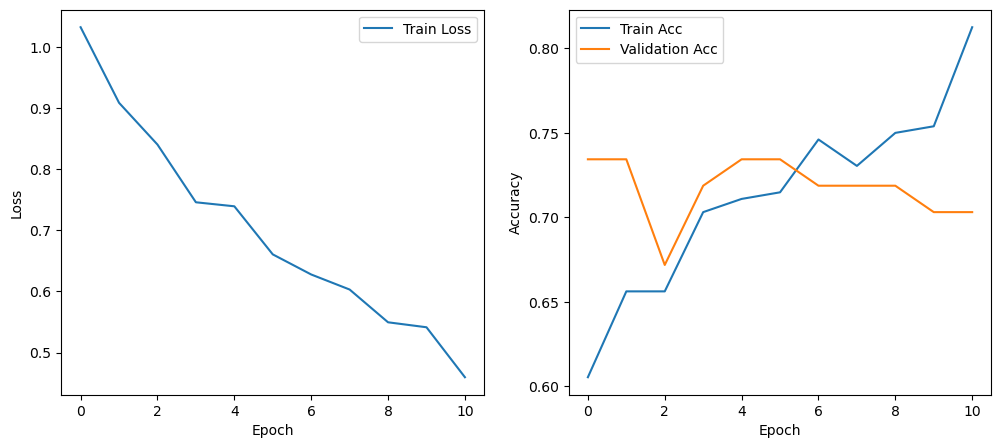

In [11]:
best_params = study.best_params

model = MLP(
    input_size=X_train.shape[1],
    hidden_size=[best_params["hidden_size_1"], best_params["hidden_size_2"]],
    output_size=len(set(y_train)),
    dropout_rate=best_params["dropout_rate"],
    learning_rate=best_params["learning_rate"]
)

# Set optimizer based on best selection
if best_params["optimizer"] == "SGD":
    model.optimizer = torch.optim.SGD(model.parameters(), lr=best_params["learning_rate"], momentum=0.9)
elif best_params["optimizer"] == "AdamW":
    model.optimizer = torch.optim.AdamW(model.parameters(), lr=best_params["learning_rate"])

# Data loaders with best batch size
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)),
                          batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)),
                        batch_size=best_params["batch_size"], shuffle=False)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)),
                         batch_size=best_params["batch_size"], shuffle=False)

# Train the final model
history = model.train_model(train_loader, val_loader, epochs=best_params["epochs"])

# Final evaluation on the test set
final_accuracy = model.evaluate(test_loader)
print(f"Final Test Accuracy with optimized parameters: {final_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()